# Group Details

## Group Name: 12

### Student 1: Denise La Gordt Dillie

### Student 2: Andreea Maican

### Student 3: Sambhav Jain

# Loading Data and Preliminaries

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from torch_geometric.data import Data
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import os
import math
import random
import time
from sklearn.metrics import r2_score, mean_absolute_error
from tqdm import tqdm
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.data import batch
from torch.nn import Linear

c:\.virtualenvs\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")

In [3]:
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state: shape (n_bodies, [x, y])

"""

example = load_array('C:/Users/Gebruiker/OneDrive - TU Eindhoven/TUe/Master/2AMM10/tue-deeplearning/assignments/assignment_2/data/task 1/train/trajectory_0.npz', task='task 1')

initial_state, terminal_state = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(initial_state)
print(f'shape of terminal state (to be predicted by model): {terminal_state.shape}')

body_idx = 2
print(f'The initial x-coordinate of the body with index {body_idx} in this trajectory was {initial_state[body_idx, 1]}')

shape of initial state (model input): (8, 5)
[[ 4.54673709 -5.27118739  5.07863417 -1.09690628 -3.66929964]
 [ 3.57509525  4.3270607  -0.08095022 -0.57868726 -2.95971243]
 [ 2.67733735 -5.15972108  5.35238208  2.42652043  1.45870728]
 [ 2.27455417 -6.79584511  2.29632123  0.30418238 -0.4065998 ]
 [ 2.38359341 -2.75861066  1.77940931 -0.07643627 -0.35954359]
 [ 4.28596268  0.34981219  4.8286224   1.35630962 -2.55760522]
 [ 3.03118516 -0.50562258 15.04631712 -0.94772523 14.98127867]
 [ 4.13530017  1.81342682  3.84375499 -0.6989711  -2.25092411]]
shape of terminal state (to be predicted by model): (8, 2)
The initial x-coordinate of the body with index 2 in this trajectory was -5.159721083543527


In [4]:
"""
This cell gives an example of loading a datapoint with numpy for task 2 / 3.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
remaining_trajectory: shape (n_bodies, time, [x, y, v_x, v_y])

Note that for this task, you are asked to evaluate performance only with regard to the predictions of the positions (x and y).
If you use the velocity of the remaining trajectory for training,
this use should be purely auxiliary for the goal of predicting the positions [x,y] over time. 
While testing performance of your model on the test set, you do not have access to v_x and v_y of the remaining trajectory.

"""

example = load_array('C:/Users/Gebruiker/OneDrive - TU Eindhoven/TUe/Master/2AMM10/tue-deeplearning/assignments/assignment_2/data/task 2_3/train/trajectory_0.npz', task='task 2')

initial_state, remaining_trajectory = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {remaining_trajectory.shape}')

body_idx = 2
time_idx = 30
print(f'The y-coordinate of the body with index {body_idx} at time with index {time_idx} in remaining_trajectory was {remaining_trajectory[body_idx, time_idx, 1]}')

test_example = load_array('C:/Users/Gebruiker/OneDrive - TU Eindhoven/TUe/Master/2AMM10/tue-deeplearning/assignments/assignment_2/data/task 2_3/test/trajectory_900.npz', task='task 3')
test_initial_state, test_remaining_trajectory = test_example
print(f'the shape of the input of a test data example is {test_initial_state.shape}')
print(f'the shape of the target of a test data example is {test_remaining_trajectory.shape}')
print(f'values of the test data example at time {time_idx}:\n {test_remaining_trajectory[:, time_idx]}')
print('note: velocity values are unobserved (NaNs) in the test data!')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 49, 4)
The y-coordinate of the body with index 2 at time with index 30 in remaining_trajectory was -0.3861544940435097
the shape of the input of a test data example is (8, 5)
the shape of the target of a test data example is (8, 49, 4)
values of the test data example at time 30:
 [[-5.85725792 -5.394571           nan         nan]
 [-6.03781257 -5.72445953         nan         nan]
 [-0.90623054 -6.93416278         nan         nan]
 [ 2.83149339 -7.50100819         nan         nan]
 [-2.85586881  1.77667501         nan         nan]
 [ 4.04424526  4.00563603         nan         nan]
 [-5.24887713 -4.83081005         nan         nan]
 [-5.81391023 -5.1109838          nan         nan]]
note: velocity values are unobserved (NaNs) in the test data!


In [5]:
test_initial_state

array([[ 4.31455329, -4.99311363, -5.10150489,  2.2491171 , -1.82520359],
       [ 2.58525749, -4.92574075, -4.7534334 , -4.81897728, -3.07212095],
       [ 2.40449047,  2.23254187, -6.04595524, -0.67381217, -0.58798851],
       [ 2.28318603,  5.6605113 , -3.76376281, -0.41268251, -1.19812499],
       [ 4.09793595, -4.73678906, -3.94704856,  1.13634781,  4.98383634],
       [ 4.5579536 , -0.08848969,  5.42483477,  1.460317  , -0.21585929],
       [ 3.42356878, -4.91282501, -4.6779343 ,  0.94123905,  2.66425652],
       [ 3.59288181, -4.48225046, -4.548729  , -2.56573061, -2.39203918]])

# Task 1

# Data Handling and Preprocessing

In [6]:
def create_graph_data_task1(initial_state, terminal_state):
    initial_state = np.array(initial_state)
    terminal_state = np.array(terminal_state)

    n_bodies = initial_state.shape[0]
    num_features = initial_state.shape[1]

    # Calculate center of mass
    total_mass = np.sum(initial_state[:, 0])
    center_of_mass_x = np.sum(initial_state[:, 1] * initial_state[:, 0]) / total_mass
    center_of_mass_y = np.sum(initial_state[:, 2] * initial_state[:, 0]) / total_mass

    # Adjust positions relative to center of mass for initial and terminal states
    initial_state[:, 1] -= center_of_mass_x
    initial_state[:, 2] -= center_of_mass_y
    
    terminal_state[:, 0] -= center_of_mass_x
    terminal_state[:, 1] -= center_of_mass_y
    
    # Find the indices of the two most massive objects
    mass_indices = np.argsort(initial_state[:, 0])
    indices = mass_indices[-2:]
    
    # Calculate the vector between the two most massive objects
    vector = initial_state[indices[1], 1:3] - initial_state[indices[0], 1:3]
    
    # Calculate the angle of rotation based on the vector
    angle = math.atan2(vector[1], vector[0])
    
    # Apply rotation to the positions
    rot_matrix = np.array([[math.cos(-angle), -math.sin(-angle)], [math.sin(-angle), math.cos(-angle)]])
    initial_state[:, 1:3] = np.matmul(rot_matrix, initial_state[:, 1:3].T).T
    terminal_state = np.matmul(rot_matrix, terminal_state.T).T
    
    # Create node features tensor
    node_features = torch.tensor(initial_state, dtype=torch.float)
    node_features = node_features.view(-1, num_features)  # Reshape to (num_nodes, num_features)

    # Create edge index tensor
    edge_index = torch.tensor([[i, j] for i in range(n_bodies) for j in range(n_bodies) if (i != j and i<j)], dtype=torch.long)
    edge_index = edge_index.t().contiguous()  # Reshape to (2, num_edges)

    # Create edge features tensor
    num_edges = edge_index.size(1)
    edge_features = torch.empty(num_edges, 1, dtype=torch.float)
    # Populate edge features with force
    for k, (i, j) in enumerate(edge_index.t()):
        dx = node_features[i, 1] - node_features[j, 1]
        dy = node_features[i, 2] - node_features[j, 2]
        distance = torch.sqrt(dx**2 + dy**2)
        force = ((node_features[i,0]*node_features[j,0])/(distance**2 + 1e-8))
        edge_features[k] = force

    # Create target tensor
    target = torch.tensor(terminal_state, dtype=torch.float).view(-1, 2)  # Reshape to (num_nodes, num_features + 1)

    # Create PyG Data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=target)

    return data

# Example usage
initial_state = [[1.0, 0.5, 0.3, 0.2, 0.1], [2.0, 0.1, 0.4, 0.3, 0.2], [0.5, 0.7, 0.8, 0.9, 1.0]]
terminal_state = [[0.3, 0.2], [0.4, 0.6], [0.8, 0.9]]

graph_data = create_graph_data_task1(initial_state, terminal_state)
print(graph_data.x, graph_data.edge_index, graph_data.edge_attr, graph_data.y)

tensor([[ 1.0000, -0.2252,  0.0762,  0.2000,  0.1000],
        [ 2.0000,  0.1871,  0.0762,  0.3000,  0.2000],
        [ 0.5000, -0.2980, -0.4574,  0.9000,  1.0000]]) tensor([[0, 0, 1],
        [1, 2, 2]]) tensor([[11.7647],
        [ 1.7241],
        [ 1.9231]]) tensor([[-0.0554,  0.2217],
        [-0.0554, -0.1906],
        [-0.3707, -0.5786]])


In [7]:
def create_dataloader_task1(data_folder, task, shuffle, batch_size, train_ratio=0.8):
    data_list = []  # List to store the Data objects

    # Loop over all files in the folder
    for filename in os.listdir(data_folder):
        file_path = os.path.join(data_folder, filename)

        # Read the data from the file (modify this part based on your file format)
        states = load_array(file_path, task=task)
        initial_state, terminal_state = states

        # Create the Data object using create_graph_data function
        data = create_graph_data_task1(initial_state, terminal_state)

        # Append the Data object to the list
        data_list.append(data)

    # Shuffle the data if specified
    if shuffle:
        random.shuffle(data_list)

    # Calculate the number of samples
    num_samples = len(data_list)

    if "train" in data_folder:
        # Calculate the number of samples for train and validation
        num_train = int(train_ratio * num_samples)
        num_val = num_samples - num_train

        # Split the data into train and validation sets
        train_data = data_list[:num_train]
        val_data = data_list[num_train:]

        # Print the number of data samples
        print(f"Number of data samples in {data_folder}: {num_samples}")
        print(f"Number of training samples: {num_train}")
        print(f"Number of validation samples: {num_val}")

        # Create data loaders for train and validation sets
        dataloader_train = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        dataloader_val = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        return dataloader_train, dataloader_val, data_list
    else:
        # Print the number of data samples
        print(f"Number of data samples in {data_folder}: {num_samples}")

        # Create a data loader for the data
        dataloader = DataLoader(data_list, batch_size=batch_size, shuffle=shuffle)

        return dataloader, data_list

# Specify the paths to your train and test data folders
data_folder_train = 'C:/Users/Gebruiker/OneDrive - TU Eindhoven/TUe/Master/2AMM10/tue-deeplearning/assignments/assignment_2/data/task 1/train'
data_folder_test = 'C:/Users/Gebruiker/OneDrive - TU Eindhoven/TUe/Master/2AMM10/tue-deeplearning/assignments/assignment_2/data/task 1/test'

# Define the batch size
batch_size = 50

# Create data loaders for train and validation sets (only if the folder contains "train")
dataloader_train, dataloader_val, data_list = create_dataloader_task1(data_folder_train, task='task 1', shuffle=True, batch_size=batch_size)

# Create a separate data loader for the test set
dataloader_test, data_list_test = create_dataloader_task1(data_folder_test, task='task 1', shuffle=False, batch_size=batch_size)

Number of data samples in C:/Users/Gebruiker/OneDrive - TU Eindhoven/TUe/Master/2AMM10/tue-deeplearning/assignments/assignment_2/data/task 1/train: 900
Number of training samples: 720
Number of validation samples: 180
Number of data samples in C:/Users/Gebruiker/OneDrive - TU Eindhoven/TUe/Master/2AMM10/tue-deeplearning/assignments/assignment_2/data/task 1/test: 100


# Model Implementation

In [8]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()

        self.conv1 = SAGEConv(5, 64)
        self.conv2 = SAGEConv(64, 128)
        self.conv3 = SAGEConv(128, 256)
        self.conv4 = SAGEConv(256, 512)
        self.conv5 = SAGEConv(512, 256)
        self.conv6 = SAGEConv(256, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = self.conv6(x, edge_index)

        return x

# Model Training

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
print(f'Loaded device: {device}')

Loaded device: cpu


In [10]:
model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_func = torch.nn.MSELoss()

def train(loader):
    model.train()
    total_loss = 0
    total_r2_score = 0
    total_mae = 0
    total_samples = 0

    for data in loader:
        data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predictions = output.detach().cpu().numpy()
        true_labels = data.y.detach().cpu().numpy()
        batch_size = true_labels.shape[0]
        total_samples += batch_size

         # R2 Score
        total_r2_score += r2_score(true_labels, predictions) * batch_size

        # MAE
        mae = mean_absolute_error(true_labels, predictions)
        total_mae += mae * batch_size

    avg_loss = total_loss / len(loader)
    avg_r2_score = total_r2_score / total_samples
    avg_mae = total_mae / total_samples

    return avg_loss, avg_r2_score, avg_mae

def evaluate(loader):
    model.eval()
    total_loss = 0
    total_r2_score = 0
    total_mae = 0
    total_samples = 0

    with torch.no_grad():
        for data in loader:
            data.to(device)
            output = model(data)
            loss = loss_func(output, data.y)
            total_loss += loss.item()

            predictions = output.detach().cpu().numpy()
            true_labels = data.y.detach().cpu().numpy()
            batch_size = true_labels.shape[0]
            total_samples += batch_size

            # R2 Score
            total_r2_score += r2_score(true_labels, predictions) * batch_size

            # MAE
            mae = mean_absolute_error(true_labels, predictions)
            total_mae += mae * batch_size

    avg_loss = total_loss / len(loader)
    avg_r2_score = total_r2_score / total_samples
    avg_mae = total_mae / total_samples

    return avg_loss, avg_r2_score, avg_mae

In [11]:
epochs = 50
start = time.time()

train_losses, train_r2_scores, train_maes = [], [], []
val_losses, val_r2_scores, val_maes = [], [], []
test_losses, test_r2_scores, test_maes = [], [], []

for epoch in tqdm(range(1, epochs + 1)):

    train_loss, train_r2_score, train_mae = train(dataloader_train)
    val_loss, val_r2_score, val_mae = evaluate(dataloader_val)
    test_loss, test_r2_score, test_mae = evaluate(dataloader_test)

    toc = time.time()
    print(f'EPOCH: {epoch:03d}, TRAIN LOSS: {train_loss:.4f}, VAL LOSS: {val_loss:.4f}, TEST LOSS: {test_loss:.4f}. TRAINING TIME SO FAR: {toc - start:.1f} s\n'
          f'TRAIN R2: {train_r2_score:.4f}, VAL R2: {val_r2_score:.4f}, TEST R2: {test_r2_score:.4f}\n'
          f'TRAIN MAE: {train_mae:.4f}, VAL MAE: {val_mae:.4f}, TEST MAE: {test_mae:.4f}\n')

    # Store metrics
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)
    train_maes.append(train_mae)

    val_losses.append(val_loss)
    val_r2_scores.append(val_r2_score)
    val_maes.append(val_mae)

    test_losses.append(test_loss)
    test_r2_scores.append(test_r2_score)
    test_maes.append(test_mae)

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:30,  1.85s/it]

EPOCH: 001, TRAIN LOSS: 13.2161, VAL LOSS: 7.9661, TEST LOSS: 6.2628. TRAINING TIME SO FAR: 1.9 s
TRAIN R2: 0.3284, VAL R2: 0.5571, TEST R2: 0.6497
TRAIN MAE: 2.7941, VAL MAE: 2.1615, TEST MAE: 1.9637



  4%|▍         | 2/50 [00:03<01:18,  1.65s/it]

EPOCH: 002, TRAIN LOSS: 8.2273, VAL LOSS: 7.1475, TEST LOSS: 6.0370. TRAINING TIME SO FAR: 3.4 s
TRAIN R2: 0.5946, VAL R2: 0.5980, TEST R2: 0.6632
TRAIN MAE: 2.0920, VAL MAE: 2.0553, TEST MAE: 1.9100



  6%|▌         | 3/50 [00:05<01:19,  1.68s/it]

EPOCH: 003, TRAIN LOSS: 7.7296, VAL LOSS: 6.6866, TEST LOSS: 5.4246. TRAINING TIME SO FAR: 5.1 s
TRAIN R2: 0.6225, VAL R2: 0.6248, TEST R2: 0.6972
TRAIN MAE: 2.0092, VAL MAE: 1.9429, TEST MAE: 1.7994



  8%|▊         | 4/50 [00:06<01:17,  1.68s/it]

EPOCH: 004, TRAIN LOSS: 7.2690, VAL LOSS: 6.6255, TEST LOSS: 5.3213. TRAINING TIME SO FAR: 6.8 s
TRAIN R2: 0.6380, VAL R2: 0.6278, TEST R2: 0.7019
TRAIN MAE: 1.9566, VAL MAE: 1.9477, TEST MAE: 1.7809



 10%|█         | 5/50 [00:08<01:16,  1.69s/it]

EPOCH: 005, TRAIN LOSS: 7.3284, VAL LOSS: 6.6488, TEST LOSS: 5.1500. TRAINING TIME SO FAR: 8.5 s
TRAIN R2: 0.6368, VAL R2: 0.6256, TEST R2: 0.7117
TRAIN MAE: 1.9637, VAL MAE: 1.9363, TEST MAE: 1.7472



 12%|█▏        | 6/50 [00:10<01:13,  1.67s/it]

EPOCH: 006, TRAIN LOSS: 7.0459, VAL LOSS: 6.7500, TEST LOSS: 5.2805. TRAINING TIME SO FAR: 10.2 s
TRAIN R2: 0.6463, VAL R2: 0.6209, TEST R2: 0.7041
TRAIN MAE: 1.9487, VAL MAE: 1.9569, TEST MAE: 1.7629



 14%|█▍        | 7/50 [00:12<01:22,  1.92s/it]

EPOCH: 007, TRAIN LOSS: 7.0056, VAL LOSS: 6.8051, TEST LOSS: 5.2349. TRAINING TIME SO FAR: 12.6 s
TRAIN R2: 0.6431, VAL R2: 0.6166, TEST R2: 0.7081
TRAIN MAE: 1.9593, VAL MAE: 1.9727, TEST MAE: 1.7731



 16%|█▌        | 8/50 [00:14<01:22,  1.96s/it]

EPOCH: 008, TRAIN LOSS: 6.5567, VAL LOSS: 6.7556, TEST LOSS: 5.2275. TRAINING TIME SO FAR: 14.6 s
TRAIN R2: 0.6651, VAL R2: 0.6200, TEST R2: 0.7073
TRAIN MAE: 1.9097, VAL MAE: 1.9679, TEST MAE: 1.7700



 18%|█▊        | 9/50 [00:16<01:16,  1.86s/it]

EPOCH: 009, TRAIN LOSS: 6.4272, VAL LOSS: 6.7231, TEST LOSS: 5.2612. TRAINING TIME SO FAR: 16.3 s
TRAIN R2: 0.6691, VAL R2: 0.6218, TEST R2: 0.7051
TRAIN MAE: 1.9088, VAL MAE: 1.9630, TEST MAE: 1.7839



 20%|██        | 10/50 [00:17<01:11,  1.78s/it]

EPOCH: 010, TRAIN LOSS: 6.1415, VAL LOSS: 6.8150, TEST LOSS: 5.1723. TRAINING TIME SO FAR: 17.9 s
TRAIN R2: 0.6819, VAL R2: 0.6190, TEST R2: 0.7115
TRAIN MAE: 1.8567, VAL MAE: 1.9820, TEST MAE: 1.7574



 22%|██▏       | 11/50 [00:19<01:07,  1.74s/it]

EPOCH: 011, TRAIN LOSS: 6.1946, VAL LOSS: 6.7489, TEST LOSS: 5.0328. TRAINING TIME SO FAR: 19.5 s
TRAIN R2: 0.6852, VAL R2: 0.6228, TEST R2: 0.7196
TRAIN MAE: 1.8398, VAL MAE: 1.9704, TEST MAE: 1.7466



 24%|██▍       | 12/50 [00:21<01:14,  1.96s/it]

EPOCH: 012, TRAIN LOSS: 6.1392, VAL LOSS: 6.8551, TEST LOSS: 5.1561. TRAINING TIME SO FAR: 22.0 s
TRAIN R2: 0.6850, VAL R2: 0.6146, TEST R2: 0.7115
TRAIN MAE: 1.8448, VAL MAE: 1.9804, TEST MAE: 1.7342



 26%|██▌       | 13/50 [00:26<01:39,  2.68s/it]

EPOCH: 013, TRAIN LOSS: 6.7390, VAL LOSS: 6.9730, TEST LOSS: 5.4168. TRAINING TIME SO FAR: 26.3 s
TRAIN R2: 0.6692, VAL R2: 0.6098, TEST R2: 0.6992
TRAIN MAE: 1.8410, VAL MAE: 1.9854, TEST MAE: 1.7865



 28%|██▊       | 14/50 [00:30<01:58,  3.29s/it]

EPOCH: 014, TRAIN LOSS: 6.5642, VAL LOSS: 6.7772, TEST LOSS: 5.2107. TRAINING TIME SO FAR: 31.0 s
TRAIN R2: 0.6792, VAL R2: 0.6184, TEST R2: 0.7091
TRAIN MAE: 1.8327, VAL MAE: 1.9602, TEST MAE: 1.7713



 30%|███       | 15/50 [00:32<01:41,  2.90s/it]

EPOCH: 015, TRAIN LOSS: 6.0047, VAL LOSS: 6.7397, TEST LOSS: 5.2820. TRAINING TIME SO FAR: 33.0 s
TRAIN R2: 0.7051, VAL R2: 0.6209, TEST R2: 0.7062
TRAIN MAE: 1.7535, VAL MAE: 1.9624, TEST MAE: 1.7791



 32%|███▏      | 16/50 [00:34<01:26,  2.54s/it]

EPOCH: 016, TRAIN LOSS: 5.6808, VAL LOSS: 6.9033, TEST LOSS: 5.1889. TRAINING TIME SO FAR: 34.7 s
TRAIN R2: 0.7074, VAL R2: 0.6121, TEST R2: 0.7116
TRAIN MAE: 1.7855, VAL MAE: 1.9826, TEST MAE: 1.7659



 34%|███▍      | 17/50 [00:36<01:20,  2.44s/it]

EPOCH: 017, TRAIN LOSS: 5.2694, VAL LOSS: 6.9904, TEST LOSS: 5.4895. TRAINING TIME SO FAR: 36.9 s
TRAIN R2: 0.7308, VAL R2: 0.6078, TEST R2: 0.6953
TRAIN MAE: 1.7079, VAL MAE: 2.0082, TEST MAE: 1.8125



 36%|███▌      | 18/50 [00:39<01:15,  2.36s/it]

EPOCH: 018, TRAIN LOSS: 5.1104, VAL LOSS: 6.9728, TEST LOSS: 5.2804. TRAINING TIME SO FAR: 39.1 s
TRAIN R2: 0.7339, VAL R2: 0.6090, TEST R2: 0.7068
TRAIN MAE: 1.6949, VAL MAE: 1.9919, TEST MAE: 1.7887



 38%|███▊      | 19/50 [00:40<01:07,  2.19s/it]

EPOCH: 019, TRAIN LOSS: 5.4924, VAL LOSS: 7.0676, TEST LOSS: 5.5155. TRAINING TIME SO FAR: 40.9 s
TRAIN R2: 0.7283, VAL R2: 0.6032, TEST R2: 0.6934
TRAIN MAE: 1.6952, VAL MAE: 2.0167, TEST MAE: 1.8319



 40%|████      | 20/50 [00:42<01:03,  2.11s/it]

EPOCH: 020, TRAIN LOSS: 4.9348, VAL LOSS: 7.3392, TEST LOSS: 5.6977. TRAINING TIME SO FAR: 42.8 s
TRAIN R2: 0.7444, VAL R2: 0.5875, TEST R2: 0.6840
TRAIN MAE: 1.6664, VAL MAE: 2.0527, TEST MAE: 1.8612



 42%|████▏     | 21/50 [00:44<00:56,  1.96s/it]

EPOCH: 021, TRAIN LOSS: 4.8569, VAL LOSS: 7.0872, TEST LOSS: 5.6329. TRAINING TIME SO FAR: 44.4 s
TRAIN R2: 0.7521, VAL R2: 0.6015, TEST R2: 0.6881
TRAIN MAE: 1.6460, VAL MAE: 2.0278, TEST MAE: 1.8403



 44%|████▍     | 22/50 [00:46<00:52,  1.89s/it]

EPOCH: 022, TRAIN LOSS: 4.7059, VAL LOSS: 7.4653, TEST LOSS: 5.6391. TRAINING TIME SO FAR: 46.1 s
TRAIN R2: 0.7611, VAL R2: 0.5789, TEST R2: 0.6852
TRAIN MAE: 1.6027, VAL MAE: 2.0682, TEST MAE: 1.8414



 46%|████▌     | 23/50 [00:48<00:51,  1.91s/it]

EPOCH: 023, TRAIN LOSS: 4.5378, VAL LOSS: 6.9566, TEST LOSS: 5.3185. TRAINING TIME SO FAR: 48.1 s
TRAIN R2: 0.7649, VAL R2: 0.6105, TEST R2: 0.7036
TRAIN MAE: 1.5984, VAL MAE: 2.0007, TEST MAE: 1.7853



 48%|████▊     | 24/50 [00:49<00:47,  1.82s/it]

EPOCH: 024, TRAIN LOSS: 4.5075, VAL LOSS: 7.7705, TEST LOSS: 5.8426. TRAINING TIME SO FAR: 49.7 s
TRAIN R2: 0.7711, VAL R2: 0.5634, TEST R2: 0.6767
TRAIN MAE: 1.5897, VAL MAE: 2.1034, TEST MAE: 1.8639



 50%|█████     | 25/50 [00:51<00:44,  1.80s/it]

EPOCH: 025, TRAIN LOSS: 4.3449, VAL LOSS: 7.5155, TEST LOSS: 6.0372. TRAINING TIME SO FAR: 51.5 s
TRAIN R2: 0.7792, VAL R2: 0.5789, TEST R2: 0.6669
TRAIN MAE: 1.5431, VAL MAE: 2.0805, TEST MAE: 1.9199



 52%|█████▏    | 26/50 [00:53<00:42,  1.77s/it]

EPOCH: 026, TRAIN LOSS: 4.6069, VAL LOSS: 7.5269, TEST LOSS: 5.8372. TRAINING TIME SO FAR: 53.2 s
TRAIN R2: 0.7730, VAL R2: 0.5771, TEST R2: 0.6769
TRAIN MAE: 1.5523, VAL MAE: 2.0846, TEST MAE: 1.8681



 54%|█████▍    | 27/50 [00:55<00:42,  1.85s/it]

EPOCH: 027, TRAIN LOSS: 4.0949, VAL LOSS: 7.6254, TEST LOSS: 6.0120. TRAINING TIME SO FAR: 55.2 s
TRAIN R2: 0.7907, VAL R2: 0.5715, TEST R2: 0.6663
TRAIN MAE: 1.5208, VAL MAE: 2.1060, TEST MAE: 1.8964



 56%|█████▌    | 28/50 [00:57<00:40,  1.86s/it]

EPOCH: 028, TRAIN LOSS: 3.6908, VAL LOSS: 8.0017, TEST LOSS: 6.0863. TRAINING TIME SO FAR: 57.1 s
TRAIN R2: 0.8084, VAL R2: 0.5508, TEST R2: 0.6636
TRAIN MAE: 1.4479, VAL MAE: 2.1425, TEST MAE: 1.9202



 58%|█████▊    | 29/50 [00:59<00:43,  2.09s/it]

EPOCH: 029, TRAIN LOSS: 3.5594, VAL LOSS: 7.9906, TEST LOSS: 6.2829. TRAINING TIME SO FAR: 59.7 s
TRAIN R2: 0.8191, VAL R2: 0.5509, TEST R2: 0.6504
TRAIN MAE: 1.4091, VAL MAE: 2.1755, TEST MAE: 1.9457



 60%|██████    | 30/50 [01:01<00:39,  1.96s/it]

EPOCH: 030, TRAIN LOSS: 3.7413, VAL LOSS: 8.2304, TEST LOSS: 6.4184. TRAINING TIME SO FAR: 61.4 s
TRAIN R2: 0.8060, VAL R2: 0.5364, TEST R2: 0.6440
TRAIN MAE: 1.4584, VAL MAE: 2.1913, TEST MAE: 1.9429



 62%|██████▏   | 31/50 [01:07<01:04,  3.37s/it]

EPOCH: 031, TRAIN LOSS: 3.7050, VAL LOSS: 7.8896, TEST LOSS: 6.0086. TRAINING TIME SO FAR: 68.0 s
TRAIN R2: 0.8131, VAL R2: 0.5564, TEST R2: 0.6685
TRAIN MAE: 1.4339, VAL MAE: 2.1376, TEST MAE: 1.9022



 64%|██████▍   | 32/50 [01:14<01:17,  4.28s/it]

EPOCH: 032, TRAIN LOSS: 3.2645, VAL LOSS: 7.3822, TEST LOSS: 5.9847. TRAINING TIME SO FAR: 74.4 s
TRAIN R2: 0.8319, VAL R2: 0.5853, TEST R2: 0.6664
TRAIN MAE: 1.3575, VAL MAE: 2.0696, TEST MAE: 1.8922



 66%|██████▌   | 33/50 [01:16<01:00,  3.58s/it]

EPOCH: 033, TRAIN LOSS: 3.0528, VAL LOSS: 8.1470, TEST LOSS: 6.2740. TRAINING TIME SO FAR: 76.4 s
TRAIN R2: 0.8431, VAL R2: 0.5411, TEST R2: 0.6525
TRAIN MAE: 1.3090, VAL MAE: 2.1782, TEST MAE: 1.9502



 68%|██████▊   | 34/50 [01:17<00:47,  2.98s/it]

EPOCH: 034, TRAIN LOSS: 2.8701, VAL LOSS: 8.1006, TEST LOSS: 6.2331. TRAINING TIME SO FAR: 77.9 s
TRAIN R2: 0.8535, VAL R2: 0.5441, TEST R2: 0.6553
TRAIN MAE: 1.2674, VAL MAE: 2.1670, TEST MAE: 1.9222



 70%|███████   | 35/50 [01:19<00:37,  2.53s/it]

EPOCH: 035, TRAIN LOSS: 2.6740, VAL LOSS: 8.3950, TEST LOSS: 6.4448. TRAINING TIME SO FAR: 79.4 s
TRAIN R2: 0.8618, VAL R2: 0.5273, TEST R2: 0.6401
TRAIN MAE: 1.2311, VAL MAE: 2.2025, TEST MAE: 1.9581



 72%|███████▏  | 36/50 [01:23<00:40,  2.87s/it]

EPOCH: 036, TRAIN LOSS: 2.6021, VAL LOSS: 7.8755, TEST LOSS: 6.4133. TRAINING TIME SO FAR: 83.1 s
TRAIN R2: 0.8679, VAL R2: 0.5574, TEST R2: 0.6456
TRAIN MAE: 1.1962, VAL MAE: 2.1482, TEST MAE: 1.9656



 74%|███████▍  | 37/50 [01:24<00:32,  2.52s/it]

EPOCH: 037, TRAIN LOSS: 2.7049, VAL LOSS: 8.4547, TEST LOSS: 6.5605. TRAINING TIME SO FAR: 84.8 s
TRAIN R2: 0.8647, VAL R2: 0.5243, TEST R2: 0.6360
TRAIN MAE: 1.1989, VAL MAE: 2.2175, TEST MAE: 1.9931



 76%|███████▌  | 38/50 [01:27<00:31,  2.62s/it]

EPOCH: 038, TRAIN LOSS: 2.2957, VAL LOSS: 8.0765, TEST LOSS: 6.4180. TRAINING TIME SO FAR: 87.6 s
TRAIN R2: 0.8816, VAL R2: 0.5445, TEST R2: 0.6427
TRAIN MAE: 1.1427, VAL MAE: 2.1662, TEST MAE: 1.9651



 78%|███████▊  | 39/50 [01:32<00:36,  3.27s/it]

EPOCH: 039, TRAIN LOSS: 2.1686, VAL LOSS: 8.3944, TEST LOSS: 6.6021. TRAINING TIME SO FAR: 92.5 s
TRAIN R2: 0.8877, VAL R2: 0.5290, TEST R2: 0.6335
TRAIN MAE: 1.0943, VAL MAE: 2.2248, TEST MAE: 1.9842



 80%|████████  | 40/50 [01:34<00:29,  2.93s/it]

EPOCH: 040, TRAIN LOSS: 2.2097, VAL LOSS: 8.5860, TEST LOSS: 6.8162. TRAINING TIME SO FAR: 94.6 s
TRAIN R2: 0.8867, VAL R2: 0.5170, TEST R2: 0.6214
TRAIN MAE: 1.1057, VAL MAE: 2.2402, TEST MAE: 2.0079



 82%|████████▏ | 41/50 [01:36<00:23,  2.62s/it]

EPOCH: 041, TRAIN LOSS: 2.1350, VAL LOSS: 8.5702, TEST LOSS: 7.0380. TRAINING TIME SO FAR: 96.5 s
TRAIN R2: 0.8944, VAL R2: 0.5177, TEST R2: 0.6077
TRAIN MAE: 1.0544, VAL MAE: 2.2215, TEST MAE: 2.0351



 84%|████████▍ | 42/50 [01:38<00:19,  2.39s/it]

EPOCH: 042, TRAIN LOSS: 1.9353, VAL LOSS: 8.4759, TEST LOSS: 6.6836. TRAINING TIME SO FAR: 98.3 s
TRAIN R2: 0.8999, VAL R2: 0.5255, TEST R2: 0.6283
TRAIN MAE: 1.0388, VAL MAE: 2.2405, TEST MAE: 2.0124



 86%|████████▌ | 43/50 [01:40<00:15,  2.28s/it]

EPOCH: 043, TRAIN LOSS: 2.0503, VAL LOSS: 8.4733, TEST LOSS: 6.8433. TRAINING TIME SO FAR: 100.4 s
TRAIN R2: 0.8970, VAL R2: 0.5229, TEST R2: 0.6181
TRAIN MAE: 1.0711, VAL MAE: 2.2495, TEST MAE: 2.0195



 88%|████████▊ | 44/50 [01:42<00:12,  2.11s/it]

EPOCH: 044, TRAIN LOSS: 1.8330, VAL LOSS: 8.1146, TEST LOSS: 6.4449. TRAINING TIME SO FAR: 102.1 s
TRAIN R2: 0.9053, VAL R2: 0.5447, TEST R2: 0.6408
TRAIN MAE: 1.0198, VAL MAE: 2.1872, TEST MAE: 1.9591



 90%|█████████ | 45/50 [01:44<00:10,  2.11s/it]

EPOCH: 045, TRAIN LOSS: 1.6339, VAL LOSS: 8.6711, TEST LOSS: 6.8576. TRAINING TIME SO FAR: 104.2 s
TRAIN R2: 0.9160, VAL R2: 0.5122, TEST R2: 0.6177
TRAIN MAE: 0.9469, VAL MAE: 2.2590, TEST MAE: 2.0244



 92%|█████████▏| 46/50 [01:46<00:08,  2.10s/it]

EPOCH: 046, TRAIN LOSS: 1.5032, VAL LOSS: 8.4664, TEST LOSS: 6.6871. TRAINING TIME SO FAR: 106.2 s
TRAIN R2: 0.9225, VAL R2: 0.5256, TEST R2: 0.6278
TRAIN MAE: 0.9104, VAL MAE: 2.2220, TEST MAE: 1.9914



 94%|█████████▍| 47/50 [01:48<00:06,  2.05s/it]

EPOCH: 047, TRAIN LOSS: 1.4829, VAL LOSS: 8.4727, TEST LOSS: 6.8702. TRAINING TIME SO FAR: 108.2 s
TRAIN R2: 0.9260, VAL R2: 0.5226, TEST R2: 0.6163
TRAIN MAE: 0.8780, VAL MAE: 2.2272, TEST MAE: 2.0195



 96%|█████████▌| 48/50 [01:50<00:04,  2.26s/it]

EPOCH: 048, TRAIN LOSS: 1.5046, VAL LOSS: 8.7157, TEST LOSS: 6.7243. TRAINING TIME SO FAR: 110.9 s
TRAIN R2: 0.9219, VAL R2: 0.5118, TEST R2: 0.6252
TRAIN MAE: 0.9113, VAL MAE: 2.2735, TEST MAE: 2.0072



 98%|█████████▊| 49/50 [01:53<00:02,  2.50s/it]

EPOCH: 049, TRAIN LOSS: 1.3394, VAL LOSS: 8.7654, TEST LOSS: 6.9516. TRAINING TIME SO FAR: 114.0 s
TRAIN R2: 0.9317, VAL R2: 0.5088, TEST R2: 0.6136
TRAIN MAE: 0.8475, VAL MAE: 2.2666, TEST MAE: 2.0356



100%|██████████| 50/50 [01:56<00:00,  2.33s/it]

EPOCH: 050, TRAIN LOSS: 1.2860, VAL LOSS: 8.4264, TEST LOSS: 6.8796. TRAINING TIME SO FAR: 116.8 s
TRAIN R2: 0.9346, VAL R2: 0.5244, TEST R2: 0.6161
TRAIN MAE: 0.8205, VAL MAE: 2.2250, TEST MAE: 2.0028



# Evaluation

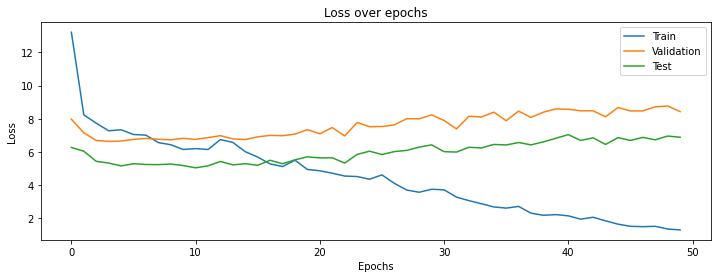

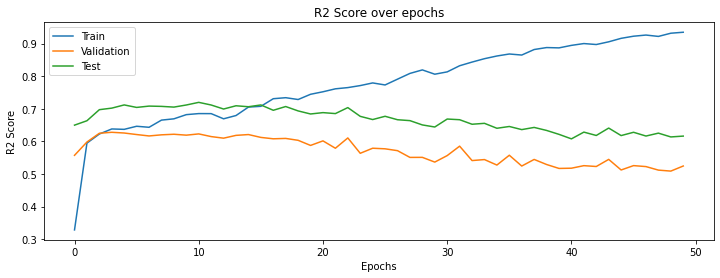

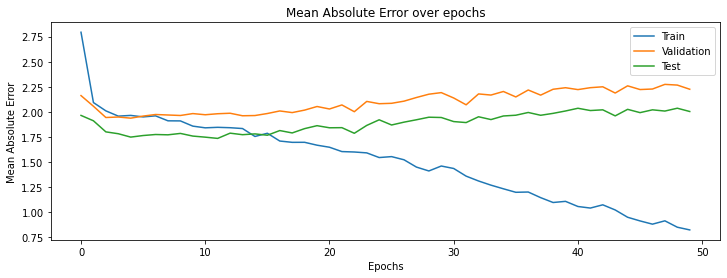

In [12]:
# Plot losses
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.plot(test_losses, label='Test')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot R2 scores
plt.figure(figsize=(12, 4))
plt.plot(train_r2_scores, label='Train')
plt.plot(val_r2_scores, label='Validation')
plt.plot(test_r2_scores, label='Test')
plt.title('R2 Score over epochs')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

# Plot MAEs
plt.figure(figsize=(12, 4))
plt.plot(train_maes, label='Train')
plt.plot(val_maes, label='Validation')
plt.plot(test_maes, label='Test')
plt.title('Mean Absolute Error over epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

Best Prediction:
Number of objects = 4
Predicted = 
 tensor([[-6.7254,  1.5280],
        [ 8.1160,  3.9622],
        [-6.4216,  2.4982],
        [ 6.3730, -2.4851]], grad_fn=<AddBackward0>),
 Ground Truth = 
 tensor([[-6.1241,  1.5668],
        [ 8.3216,  1.8433],
        [-8.3659,  2.2316],
        [ 6.4287, -2.9754]])


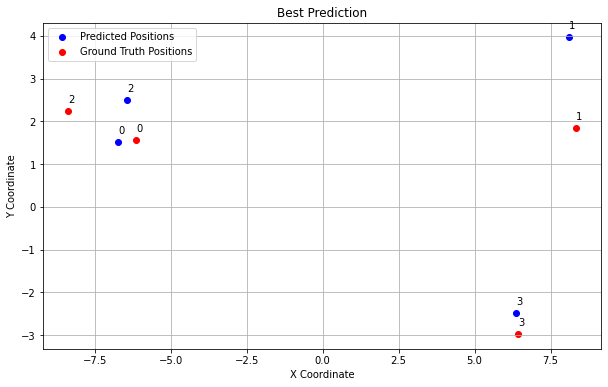

Worst Prediction:
Number of objects = 8
Predicted = 
 tensor([[ 7.1233,  9.4702],
        [ 0.3874, -0.0796],
        [ 3.5055,  2.5907],
        [-4.8857, -5.7391],
        [-0.4185,  1.3705],
        [ 4.7395,  4.2098],
        [-2.0596, -4.5620],
        [-1.9794, -4.2427]], grad_fn=<AddBackward0>),
 Ground Truth = 
 tensor([[ 0.0167,  5.4419],
        [ 0.5348, -7.1306],
        [ 1.2346,  6.2574],
        [ 6.4766,  0.2680],
        [ 0.9324,  4.9514],
        [ 0.3648,  6.3364],
        [-2.7643, -4.7080],
        [-2.4013, -5.5557]])


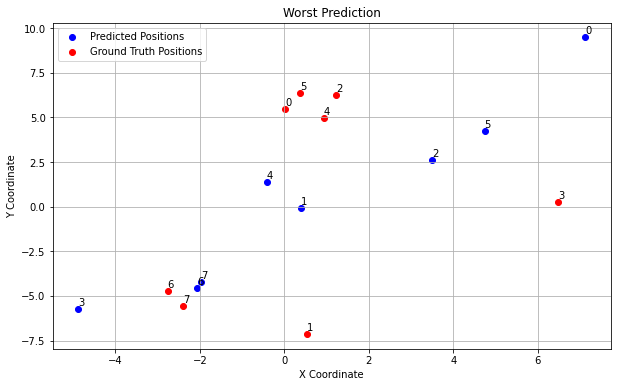

In [16]:
def plot_objects(pred, true, title):
    """
    Function to plot the predicted and true positions of the objects.

    Parameters:
    pred (tensor): Predicted positions of the objects.
    true (tensor): True positions of the objects.
    title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(pred[:, 0].detach().numpy(), pred[:, 1].detach().numpy(), c='blue', label='Predicted Positions')
    for i in range(len(pred)):
        plt.annotate(i, (pred[i,0],pred[i,1]+0.2))
    plt.scatter(true[:, 0].detach().numpy(), true[:, 1].detach().numpy(), c='red', label='Ground Truth Positions')
    for i in range(len(true)):
        plt.annotate(i, (true[i,0],true[i,1]+0.2))
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def find_best_worst_predictions(data_list):
    """
    Function to find the best and worst predictions based on the norm of the difference between the predicted and true positions.

    Parameters:
    data_list (list): List of data examples.

    Returns:
    best_idx (int): Index of the best prediction.
    worst_idx (int): Index of the worst prediction.
    """
    best_idx = None
    worst_idx = None
    best_distance = float('inf')
    worst_distance = float('-inf')

    # Iterate through the test set to find the best and worst predictions
    for idx, example in enumerate(data_list):
        pred = model(example)
        true = example.y
        distance = torch.norm(pred - true)
        if distance < best_distance:
            best_distance = distance
            best_idx = idx
        if distance > worst_distance:
            worst_distance = distance
            worst_idx = idx

    return best_idx, worst_idx

def test_example(idx, data_list, title):
    """
    Function to test a single example and plot the predicted and true positions.

    Parameters:
    idx (int): Index of the example in the data list.
    data_list (list): List of data examples.
    title (str): Title of the plot.
    """
    example = data_list[idx]
    print(f'Number of objects = {example.x.shape[0]}')
    pred = model(example)
    true = example.y
    print(f'Predicted = \n {pred},\n Ground Truth = \n {true}')
    plot_objects(pred, true, title)

# Find the indices of the best and worst predictions
best_idx, worst_idx = find_best_worst_predictions(data_list_test)

print("Best Prediction:")
# Test and plot the best prediction
test_example(best_idx, data_list_test, 'Best Prediction')

print("Worst Prediction:")
# Test and plot the worst prediction
test_example(worst_idx, data_list_test, 'Worst Prediction')

Linear Baseline:
Train - R2 Score: -1.276036925794152, MAE: 4.853354083849736
Validation - R2 Score: -1.0973950570633868, MAE: 4.604953109240923
Test - R2 Score: -1.1536830208310371, MAE: 4.598807295163472

Constant Baseline:
Train - R2 Score: 0.27537215484434, MAE: 2.9720276647787287
Validation - R2 Score: 0.29204692467617205, MAE: 2.8700055726341795
Test - R2 Score: 0.3450025863825506, MAE: 2.792816334300571

Trained Model:
Train - R2 Score: 0.9348032498584494, MAE: 0.7732898139525618
Validation - R2 Score: 0.5484032302511169, MAE: 2.1814374187262127
Test - R2 Score: 0.6105035056831194, MAE: 2.016734129852719


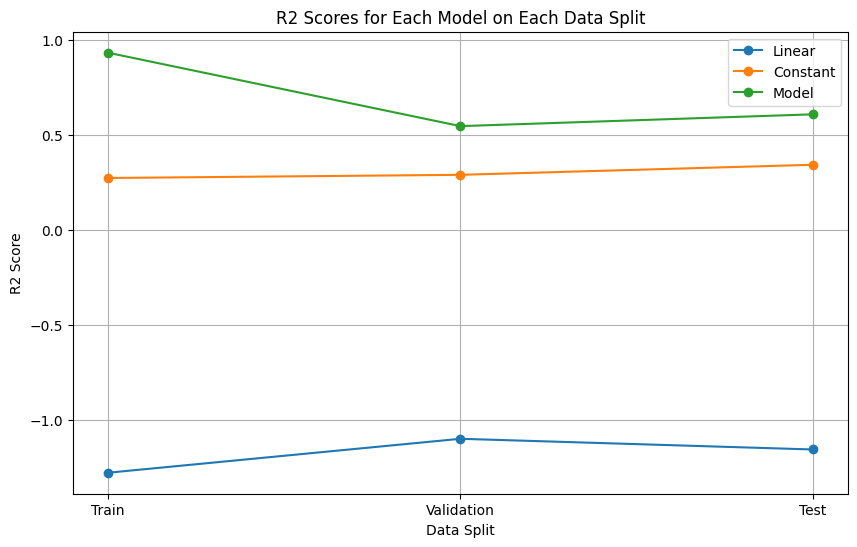

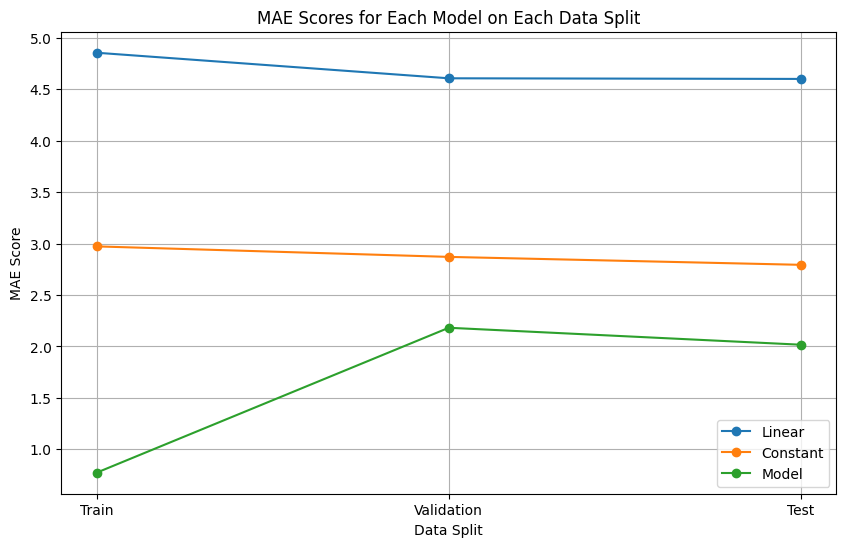

In [ ]:
# Define the linear baseline function
def linear_baseline(initial_state, t):
    """
    The linear baseline predicts the final position as the initial position plus velocity times time.
    """
    final_state = initial_state[:, 1:3] + t * initial_state[:, 3:5]
    return final_state

# Define the constant baseline function
def constant_baseline(initial_state):
    """
    The constant baseline predicts the final position to be the same as the initial position.
    """
    final_state = initial_state[:, 1:3]
    return final_state

# Define the function to evaluate a baseline
def evaluate_baseline(baseline_func, data_list, t=None):
    """
    This function evaluates a baseline function on a list of data. It calculates the R2 score and MAE.
    """
    total_r2_score = 0
    total_mae = 0
    total_samples = 0

    for example in data_list:
        if t is not None:
            pred = baseline_func(example.x.detach().numpy(), t)
        else:
            pred = baseline_func(example.x.detach().numpy())
        true = example.y.detach().numpy()
        batch_size = true.shape[0]
        total_samples += batch_size

        # Calculate R2 Score
        total_r2_score += r2_score(true, pred) * batch_size

        # Calculate MAE
        mae = mean_absolute_error(true, pred)
        total_mae += mae * batch_size

    avg_r2_score = total_r2_score / total_samples
    avg_mae = total_mae / total_samples

    return avg_r2_score, avg_mae

# Define the function to evaluate the model
def evaluate_model(model, data_list):
    """
    This function evaluates a model on a list of data. It calculates the R2 score and MAE.
    """
    total_r2_score = 0
    total_mae = 0
    total_samples = 0

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations
        for example in data_list:
            pred = model(example)  # Pass the data through the model
            true = example.y
            batch_size = true.shape[0]
            total_samples += batch_size

            # Calculate R2 Score
            total_r2_score += r2_score(true.detach().numpy(), pred.detach().numpy()) * batch_size

            # Calculate MAE
            mae = mean_absolute_error(true.detach().numpy(), pred.detach().numpy())
            total_mae += mae * batch_size

    avg_r2_score = total_r2_score / total_samples
    avg_mae = total_mae / total_samples

    return avg_r2_score, avg_mae

# Initialize dictionaries to store the R2 and MAE scores for each model and each data split
r2_scores = {"Linear": [], "Constant": [], "Model": []}
mae_scores = {"Linear": [], "Constant": [], "Model": []}

# Define the time at which you want to predict the position
t = 5.0

# Evaluate the linear baseline
print("Linear Baseline:")
for split_name, data_list in zip(["Train", "Validation", "Test"], [dataloader_train, dataloader_val, dataloader_test]):
    linear_r2_score, linear_mae = evaluate_baseline(linear_baseline, data_list, t)
    print(f'{split_name} - R2 Score: {linear_r2_score}, MAE: {linear_mae}')
    r2_scores["Linear"].append(linear_r2_score)
    mae_scores["Linear"].append(linear_mae)

# Evaluate the constant baseline
print("\nConstant Baseline:")
for split_name, data_list in zip(["Train", "Validation", "Test"], [dataloader_train, dataloader_val, dataloader_test]):
    constant_r2_score, constant_mae = evaluate_baseline(constant_baseline, data_list)
    print(f'{split_name} - R2 Score: {constant_r2_score}, MAE: {constant_mae}')
    r2_scores["Constant"].append(constant_r2_score)
    mae_scores["Constant"].append(constant_mae)

# Evaluate the trained model
print("\nTrained Model:")
for split_name, data_list in zip(["Train", "Validation", "Test"], [dataloader_train, dataloader_val, dataloader_test]):
    model_r2_score, model_mae = evaluate_model(model, data_list)
    print(f'{split_name} - R2 Score: {model_r2_score}, MAE: {model_mae}')
    r2_scores["Model"].append(model_r2_score)
    mae_scores["Model"].append(model_mae)

# Create a list of the data splits for the x-axis of the plots
splits = ["Train", "Validation", "Test"]

# Create a plot for the R2 scores
plt.figure(figsize=(10, 6))
for model, scores in r2_scores.items():
    plt.plot(splits, scores, marker='o', label=model)
plt.title('R2 Scores for Each Model on Each Data Split')
plt.xlabel('Data Split')
plt.ylabel('R2 Score')
plt.legend()
plt.grid(True)
plt.show()

# Create a plot for the MAE scores
plt.figure(figsize=(10, 6))
for model, scores in mae_scores.items():
    plt.plot(splits, scores, marker='o', label=model)
plt.title('MAE Scores for Each Model on Each Data Split')
plt.xlabel('Data Split')
plt.ylabel('MAE Score')
plt.legend()
plt.grid(True)
plt.show()

# Task 2

# Data Handling and Preprocessing


In [ ]:
def create_graph_data_task2(initial_state, trajectory):
    initial_state = np.array(initial_state)
    trajectory = np.array(trajectory)

    n_bodies = initial_state.shape[0]
    num_features = initial_state.shape[1]

    # Calculate center of mass
    total_mass = np.sum(initial_state[:, 0])
    center_of_mass_x = np.sum(initial_state[:, 1] * initial_state[:, 0]) / total_mass
    center_of_mass_y = np.sum(initial_state[:, 2] * initial_state[:, 0]) / total_mass

    # Adjust positions relative to center of mass for initial and terminal states
    initial_state[:, 1] -= center_of_mass_x
    initial_state[:, 2] -= center_of_mass_y

    trajectory[:, :, 0] -= center_of_mass_x
    trajectory[:, :, 1] -= center_of_mass_y

    # Find the indices of the two most massive objects
    mass_indices = np.argsort(initial_state[:, 0])
    indices = mass_indices[-2:]

    # Calculate the vector between the two most massive objects
    vector = initial_state[indices[1], 1:3] - initial_state[indices[0], 1:3]

    # Calculate the angle of rotation based on the vector
    angle = math.atan2(vector[1], vector[0])

    # Apply rotation to the positions
    rot_matrix = np.array([[math.cos(-angle), -math.sin(-angle)], [math.sin(-angle), math.cos(-angle)]])
    initial_state[:, 1:3] = np.matmul(rot_matrix, initial_state[:, 1:3].T).T
    for i in range(trajectory.shape[1]):
        trajectory[:, i, :2] = np.matmul(rot_matrix, trajectory[:, i, :2].T).T

    # Create node features tensor
    node_features = torch.tensor(initial_state, dtype=torch.float)
    node_features = node_features.view(-1, num_features)  # Reshape to (num_nodes, num_features)

    # Create edge index tensor
    edge_index = torch.tensor([[i, j] for i in range(n_bodies) for j in range(n_bodies) if (i != j and i<j)], dtype=torch.long)
    edge_index = edge_index.t().contiguous()  # Reshape to (2, num_edges)

    # Create edge features tensor
    num_edges = edge_index.size(1)
    edge_features = torch.empty(num_edges, 1, dtype=torch.float)
    # Populate edge features with force
    for k, (i, j) in enumerate(edge_index.t()):
        dx = node_features[i, 1] - node_features[j, 1]
        dy = node_features[i, 2] - node_features[j, 2]
        distance = torch.sqrt(dx**2 + dy**2)
        force = ((node_features[i,0]*node_features[j,0])/(distance**2 + 1e-8))
        edge_features[k] = force

     # Create target tensor
    target = torch.tensor(trajectory, dtype=torch.float).reshape(n_bodies, -1, 4)

    # Create PyG Data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=target)

    return data

# Example usage
initial_state = [[1.0, 0.5, 0.3, 0.2, 0.1], [2.0, 0.1, 0.4, 0.3, 0.2], [0.5, 0.7, 0.8, 0.9, 1.0]]
trajectory = [
    [[0.3, 0.2], [0.4, 0.3], [0.5, 0.4], [0.6, 0.5]],
    [[0.4, 0.6], [0.5, 0.7], [0.6, 0.8], [0.7, 0.9]],
    [[0.8, 0.9], [0.9, 1.0], [1.0, 1.1], [1.1, 1.2]]
]

graph_data = create_graph_data_task2(initial_state, trajectory)
print(graph_data.x, graph_data.edge_index, graph_data.edge_attr, graph_data.y)

tensor([[ 1.0000, -0.2252,  0.0762,  0.2000,  0.1000],
        [ 2.0000,  0.1871,  0.0762,  0.3000,  0.2000],
        [ 0.5000, -0.2980, -0.4574,  0.9000,  1.0000]]) tensor([[0, 0, 1],
        [1, 2, 2]]) tensor([[11.7647],
        [ 1.7241],
        [ 1.9231]]) tensor([[[-0.0554,  0.2217, -0.1282,  0.1005],
         [-0.2010, -0.0208, -0.2737, -0.1421]],

        [[-0.0554, -0.1906, -0.1282, -0.3118],
         [-0.2010, -0.4331, -0.2737, -0.5544]],

        [[-0.3707, -0.5786, -0.4435, -0.6999],
         [-0.5163, -0.8212, -0.5890, -0.9424]]])


In [ ]:
def create_dataloader_task2(data_folder, task, shuffle, batch_size, train_ratio=0.8):
    data_list = []  # List to store the Data objects

    # Loop over all files in the folder
    for filename in os.listdir(data_folder):
        file_path = os.path.join(data_folder, filename)

        # Read the data from the file (modify this part based on your file format)
        states = load_array(file_path, task=task)
        initial_state, trajectory = states

        # Create the Data object using create_graph_data function
        data = create_graph_data_task2(initial_state, trajectory)

        # Handle NaN values in the target data only for the test set
        if "test" in data_folder:
            if torch.isnan(data.y).any():
                nan_mask = torch.isnan(data.y)
                data.y[nan_mask] = torch.mean(data.y[~nan_mask])

        # Append the Data object to the list
        data_list.append(data)

    # Shuffle the data if specified
    if shuffle:
        random.shuffle(data_list)

    # Calculate the number of samples
    num_samples = len(data_list)

    if "train" in data_folder:
        # Calculate the number of samples for train and validation
        num_train = int(train_ratio * num_samples)
        num_val = num_samples - num_train

        # Split the data into train and validation sets
        train_data = data_list[:num_train]
        val_data = data_list[num_train:]

        # Print the number of data samples
        print(f"Number of data samples in {data_folder}: {num_samples}")
        print(f"Number of training samples: {num_train}")
        print(f"Number of validation samples: {num_val}")

        # Create data loaders for train and validation sets
        dataloader_train = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        dataloader_val = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        return dataloader_train, dataloader_val, data_list
    else:
        # Print the number of data samples
        print(f"Number of data samples in {data_folder}: {num_samples}")

        # Create a data loader for the data
        dataloader = DataLoader(data_list, batch_size=batch_size, shuffle=shuffle)

        return dataloader, data_list

# Specify the paths to your train and test data folders
data_folder_train = '/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/train'
data_folder_test = '/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/test'

# Define the batch size
batch_size = 50

# Create data loaders for train and validation sets (only if the folder contains "train")
dataloader_train, dataloader_val, data_list = create_dataloader_task2(data_folder_train, task='task 2', shuffle=True, batch_size=batch_size)

# Create a separate data loader for the test set
dataloader_test, data_list_test = create_dataloader_task2(data_folder_test, task='task 2', shuffle=False, batch_size=batch_size)

Number of data samples in /Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/train: 900
Number of training samples: 720
Number of validation samples: 180
Number of data samples in /Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/test: 100


# Model Implementation

In [ ]:
class GNN_LSTM(torch.nn.Module):
    def __init__(self):
        super(GNN_LSTM, self).__init__()

        self.conv1 = SAGEConv(5, 64)
        self.conv2 = SAGEConv(64, 128)
        self.conv3 = SAGEConv(128, 256)
        self.conv4 = SAGEConv(256, 512)
        self.conv5 = SAGEConv(512, 256)

        self.pool = global_mean_pool

        self.lstm = nn.LSTM(256, 128, num_layers=1, batch_first=True)
        self.fc = nn.Linear(128, 4)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))

        # Apply global mean pooling to get a fixed-size vector for each graph
        x_pool = self.pool(x, batch)

        # Repeat the pooled graph embeddings for each sequence in the corresponding graph
        x = x_pool[batch]

        # Expand dimensions to match the input shape expected by the LSTM
        x = x.unsqueeze(1).expand(-1, data.y.size(1), -1)

        # Pass x through LSTM
        x, _ = self.lstm(x)

        # Pass the output of LSTM through fully connected layer
        x = self.fc(x)

        return x

# Model Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
print(f'Loaded device: {device}')

Loaded device: cpu


In [ ]:
def calculate_cosine_similarity(true_labels, predictions):
    """
    This function calculates the cosine similarity between true_labels and predictions for each sample individually.
    It reshapes the inputs to 2D arrays and computes the cosine similarity using the cosine_similarity function.

    Parameters:
    true_labels (numpy array): The ground truth values. It is a 3D numpy array with shape (n_samples, n_sequence, n_outputs).
    predictions (numpy array): The predicted values. It is a 3D numpy array with shape (n_samples, n_sequence, n_outputs).

    Returns:
    numpy array: The cosine similarity values for each sample.
    """
    num_samples = true_labels.shape[0]
    cosine_sims = np.zeros(num_samples)

    for i in range(num_samples):
        true_label = true_labels[i]
        prediction = predictions[i]

        # Reshape to 2D arrays
        true_label_2d = true_label.reshape(-1, true_label.shape[-1])
        prediction_2d = prediction.reshape(-1, prediction.shape[-1])

        cosine_sim = cosine_similarity(true_label_2d, prediction_2d)[0][0]
        cosine_sims[i] = cosine_sim

    return cosine_sims

def rmse_3d(y_true, y_pred):
    """
    This function calculates the Root Mean Square Error (RMSE) for 3D inputs. It computes the RMSE for each point in the sequence
    and then returns the average error.

    Parameters:
    y_true (numpy array): The ground truth values. It is a 3D numpy array with shape (n_samples, n_sequence, n_outputs).
    y_pred (numpy array): The predicted values. It is a 3D numpy array with shape (n_samples, n_sequence, n_outputs).

    Returns:
    float: The average RMSE for all points in the sequence.
    """
    assert y_true.shape == y_pred.shape
    mse = np.mean((y_true - y_pred) ** 2, axis=(1, 2))
    rmse = np.sqrt(mse)

    return np.mean(rmse)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

model = GNN_LSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_func = torch.nn.MSELoss()

def train(loader):
    model.train()
    total_loss = 0
    total_samples = 0
    total_rmse = 0
    total_cosine_similarity = 0

    for data in loader:
        data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        total_samples += data.num_graphs
        predictions = output.detach().cpu().numpy()
        true_labels = data.y.detach().cpu().numpy()

        # RMSE
        total_rmse += rmse_3d(true_labels, predictions) * data.num_graphs

        # Cosine Similarity
        cosine_sims = calculate_cosine_similarity(true_labels, predictions)
        total_cosine_similarity += np.sum(cosine_sims)

    avg_loss = total_loss / total_samples
    avg_rmse = total_rmse / total_samples
    avg_cosine_sim = total_cosine_similarity / total_samples

    return avg_loss, avg_rmse, avg_cosine_sim

def evaluate(loader):
    model.eval()
    total_loss = 0
    total_samples = 0
    total_rmse = 0
    total_cosine_similarity = 0

    for data in loader:
        data.to(device)
        output = model(data)
        loss = loss_func(output, data.y)
        total_loss += loss.item() * data.num_graphs
        total_samples += data.num_graphs
        predictions = output.detach().cpu().numpy()
        true_labels = data.y.detach().cpu().numpy()

        # RMSE
        total_rmse += rmse_3d(true_labels, predictions) * data.num_graphs

        # Cosine Similarity
        cosine_sims = calculate_cosine_similarity(true_labels, predictions)
        total_cosine_similarity += np.sum(cosine_sims)

    avg_loss = total_loss / total_samples
    avg_rmse = total_rmse / total_samples
    avg_cosine_sim = total_cosine_similarity / total_samples

    return avg_loss, avg_rmse, avg_cosine_sim

In [ ]:
epochs = 50
start = time.time()

train_losses, train_rmses, train_cosine_sims = [], [], []
val_losses, val_rmses, val_cosine_sims = [], [], []
test_losses, test_rmses, test_cosine_sims = [], [], []

for epoch in tqdm(range(1, epochs + 1)):
    train_loss, train_rmse, train_cosine_sim = train(dataloader_train)
    val_loss, val_rmse, val_cosine_sim = evaluate(dataloader_val)
    test_loss, test_rmse, test_cosine_sim = evaluate(dataloader_test)

    toc = time.time()
    print(f'EPOCH: {epoch:03d}, TRAIN LOSS: {train_loss:.4f}, VAL LOSS: {val_loss:.4f}, TEST LOSS: {test_loss:.4f}. TRAINING TIME SO FAR: {toc - start:.1f} s\n'
          f'TRAIN COSINE SIM: {train_cosine_sim:.4f}, VAL COSINE SIM: {val_cosine_sim:.4f}, TEST COSINE SIM: {test_cosine_sim:.4f}\n'
          f'TRAIN RMSE: {train_rmse:.4f}, VAL RMSE: {val_rmse:.4f}, TEST RMSE: {test_rmse:.4f}\n')

    # Store metrics
    train_losses.append(train_loss)
    train_cosine_sims.append(train_cosine_sim)
    train_rmses.append(train_rmse)

    val_losses.append(val_loss)
    val_cosine_sims.append(val_cosine_sim)
    val_rmses.append(val_rmse)

    test_losses.append(test_loss)
    test_cosine_sims.append(test_cosine_sim)
    test_rmses.append(test_rmse)

  2%|▏         | 1/50 [00:02<01:38,  2.00s/it]

EPOCH: 001, TRAIN LOSS: 9.7081, VAL LOSS: 9.1622, TEST LOSS: 9.2092. TRAINING TIME SO FAR: 2.0 s
TRAIN COSINE SIM: 0.0471, VAL COSINE SIM: -0.0410, TEST COSINE SIM: -0.1137
TRAIN RMSE: 2.9402, VAL RMSE: 2.8711, TEST RMSE: 2.8650



  4%|▍         | 2/50 [00:03<01:35,  1.99s/it]

EPOCH: 002, TRAIN LOSS: 9.6685, VAL LOSS: 9.1487, TEST LOSS: 9.2033. TRAINING TIME SO FAR: 4.0 s
TRAIN COSINE SIM: 0.0888, VAL COSINE SIM: -0.0331, TEST COSINE SIM: -0.1624
TRAIN RMSE: 2.9362, VAL RMSE: 2.8733, TEST RMSE: 2.8694



  6%|▌         | 3/50 [00:05<01:33,  2.00s/it]

EPOCH: 003, TRAIN LOSS: 9.6463, VAL LOSS: 9.1271, TEST LOSS: 9.2157. TRAINING TIME SO FAR: 6.0 s
TRAIN COSINE SIM: 0.1320, VAL COSINE SIM: 0.1871, TEST COSINE SIM: 0.1020
TRAIN RMSE: 2.9379, VAL RMSE: 2.8691, TEST RMSE: 2.8643



  8%|▊         | 4/50 [00:07<01:31,  2.00s/it]

EPOCH: 004, TRAIN LOSS: 9.6095, VAL LOSS: 9.0506, TEST LOSS: 9.0902. TRAINING TIME SO FAR: 8.0 s
TRAIN COSINE SIM: 0.2049, VAL COSINE SIM: 0.2026, TEST COSINE SIM: 0.3207
TRAIN RMSE: 2.9364, VAL RMSE: 2.8684, TEST RMSE: 2.8598



 10%|█         | 5/50 [00:09<01:29,  2.00s/it]

EPOCH: 005, TRAIN LOSS: 9.5872, VAL LOSS: 9.0459, TEST LOSS: 9.1113. TRAINING TIME SO FAR: 10.0 s
TRAIN COSINE SIM: 0.3370, VAL COSINE SIM: 0.3044, TEST COSINE SIM: 0.3124
TRAIN RMSE: 2.9344, VAL RMSE: 2.8654, TEST RMSE: 2.8603



 12%|█▏        | 6/50 [00:12<01:28,  2.02s/it]

EPOCH: 006, TRAIN LOSS: 9.5651, VAL LOSS: 9.0232, TEST LOSS: 9.0514. TRAINING TIME SO FAR: 12.0 s
TRAIN COSINE SIM: 0.3627, VAL COSINE SIM: 0.2424, TEST COSINE SIM: 0.3727
TRAIN RMSE: 2.9338, VAL RMSE: 2.8661, TEST RMSE: 2.8554



 14%|█▍        | 7/50 [00:14<01:26,  2.01s/it]

EPOCH: 007, TRAIN LOSS: 9.5459, VAL LOSS: 9.0187, TEST LOSS: 9.0564. TRAINING TIME SO FAR: 14.1 s
TRAIN COSINE SIM: 0.3942, VAL COSINE SIM: 0.3787, TEST COSINE SIM: 0.4038
TRAIN RMSE: 2.9303, VAL RMSE: 2.8620, TEST RMSE: 2.8530



 16%|█▌        | 8/50 [00:16<01:25,  2.04s/it]

EPOCH: 008, TRAIN LOSS: 9.5282, VAL LOSS: 8.9989, TEST LOSS: 9.0383. TRAINING TIME SO FAR: 16.1 s
TRAIN COSINE SIM: 0.3980, VAL COSINE SIM: 0.3288, TEST COSINE SIM: 0.4256
TRAIN RMSE: 2.9307, VAL RMSE: 2.8631, TEST RMSE: 2.8542



 18%|█▊        | 9/50 [00:18<01:24,  2.07s/it]

EPOCH: 009, TRAIN LOSS: 9.5194, VAL LOSS: 8.9875, TEST LOSS: 9.0211. TRAINING TIME SO FAR: 18.3 s
TRAIN COSINE SIM: 0.4112, VAL COSINE SIM: 0.3894, TEST COSINE SIM: 0.4858
TRAIN RMSE: 2.9299, VAL RMSE: 2.8621, TEST RMSE: 2.8509



 20%|██        | 10/50 [00:20<01:23,  2.09s/it]

EPOCH: 010, TRAIN LOSS: 9.5197, VAL LOSS: 8.9941, TEST LOSS: 9.0364. TRAINING TIME SO FAR: 20.4 s
TRAIN COSINE SIM: 0.4358, VAL COSINE SIM: 0.3992, TEST COSINE SIM: 0.4419
TRAIN RMSE: 2.9302, VAL RMSE: 2.8625, TEST RMSE: 2.8527



 22%|██▏       | 11/50 [00:22<01:21,  2.10s/it]

EPOCH: 011, TRAIN LOSS: 9.5179, VAL LOSS: 9.0014, TEST LOSS: 9.0503. TRAINING TIME SO FAR: 22.5 s
TRAIN COSINE SIM: 0.4437, VAL COSINE SIM: 0.4334, TEST COSINE SIM: 0.4705
TRAIN RMSE: 2.9278, VAL RMSE: 2.8614, TEST RMSE: 2.8498



 24%|██▍       | 12/50 [00:24<01:19,  2.10s/it]

EPOCH: 012, TRAIN LOSS: 9.5107, VAL LOSS: 8.9863, TEST LOSS: 9.0203. TRAINING TIME SO FAR: 24.6 s
TRAIN COSINE SIM: 0.4361, VAL COSINE SIM: 0.4303, TEST COSINE SIM: 0.5032
TRAIN RMSE: 2.9281, VAL RMSE: 2.8610, TEST RMSE: 2.8462



 26%|██▌       | 13/50 [00:26<01:17,  2.10s/it]

EPOCH: 013, TRAIN LOSS: 9.5028, VAL LOSS: 8.9854, TEST LOSS: 9.0146. TRAINING TIME SO FAR: 26.7 s
TRAIN COSINE SIM: 0.4446, VAL COSINE SIM: 0.4537, TEST COSINE SIM: 0.5469
TRAIN RMSE: 2.9273, VAL RMSE: 2.8604, TEST RMSE: 2.8450



 28%|██▊       | 14/50 [00:28<01:15,  2.11s/it]

EPOCH: 014, TRAIN LOSS: 9.4984, VAL LOSS: 8.9909, TEST LOSS: 9.0240. TRAINING TIME SO FAR: 28.9 s
TRAIN COSINE SIM: 0.4584, VAL COSINE SIM: 0.4278, TEST COSINE SIM: 0.5130
TRAIN RMSE: 2.9261, VAL RMSE: 2.8609, TEST RMSE: 2.8486



 30%|███       | 15/50 [00:30<01:13,  2.10s/it]

EPOCH: 015, TRAIN LOSS: 9.5037, VAL LOSS: 8.9856, TEST LOSS: 9.0204. TRAINING TIME SO FAR: 30.9 s
TRAIN COSINE SIM: 0.4598, VAL COSINE SIM: 0.4676, TEST COSINE SIM: 0.5203
TRAIN RMSE: 2.9268, VAL RMSE: 2.8588, TEST RMSE: 2.8443



 32%|███▏      | 16/50 [00:33<01:11,  2.10s/it]

EPOCH: 016, TRAIN LOSS: 9.5035, VAL LOSS: 9.0069, TEST LOSS: 9.0616. TRAINING TIME SO FAR: 33.1 s
TRAIN COSINE SIM: 0.4723, VAL COSINE SIM: 0.4334, TEST COSINE SIM: 0.4991
TRAIN RMSE: 2.9264, VAL RMSE: 2.8615, TEST RMSE: 2.8487



 34%|███▍      | 17/50 [00:35<01:09,  2.10s/it]

EPOCH: 017, TRAIN LOSS: 9.5076, VAL LOSS: 8.9843, TEST LOSS: 9.0202. TRAINING TIME SO FAR: 35.1 s
TRAIN COSINE SIM: 0.4592, VAL COSINE SIM: 0.4735, TEST COSINE SIM: 0.5281
TRAIN RMSE: 2.9266, VAL RMSE: 2.8589, TEST RMSE: 2.8453



 36%|███▌      | 18/50 [00:37<01:07,  2.10s/it]

EPOCH: 018, TRAIN LOSS: 9.5137, VAL LOSS: 8.9844, TEST LOSS: 9.0182. TRAINING TIME SO FAR: 37.3 s
TRAIN COSINE SIM: 0.4846, VAL COSINE SIM: 0.4725, TEST COSINE SIM: 0.5437
TRAIN RMSE: 2.9270, VAL RMSE: 2.8594, TEST RMSE: 2.8443



 38%|███▊      | 19/50 [00:39<01:04,  2.10s/it]

EPOCH: 019, TRAIN LOSS: 9.5063, VAL LOSS: 8.9864, TEST LOSS: 9.0214. TRAINING TIME SO FAR: 39.3 s
TRAIN COSINE SIM: 0.4747, VAL COSINE SIM: 0.4275, TEST COSINE SIM: 0.5083
TRAIN RMSE: 2.9264, VAL RMSE: 2.8590, TEST RMSE: 2.8468



 40%|████      | 20/50 [00:41<01:02,  2.10s/it]

EPOCH: 020, TRAIN LOSS: 9.5090, VAL LOSS: 8.9862, TEST LOSS: 9.0350. TRAINING TIME SO FAR: 41.4 s
TRAIN COSINE SIM: 0.4885, VAL COSINE SIM: 0.4406, TEST COSINE SIM: 0.4761
TRAIN RMSE: 2.9248, VAL RMSE: 2.8604, TEST RMSE: 2.8498



 42%|████▏     | 21/50 [00:43<01:01,  2.11s/it]

EPOCH: 021, TRAIN LOSS: 9.4973, VAL LOSS: 8.9841, TEST LOSS: 9.0233. TRAINING TIME SO FAR: 43.6 s
TRAIN COSINE SIM: 0.4873, VAL COSINE SIM: 0.4791, TEST COSINE SIM: 0.5165
TRAIN RMSE: 2.9258, VAL RMSE: 2.8573, TEST RMSE: 2.8451



 44%|████▍     | 22/50 [00:45<00:58,  2.09s/it]

EPOCH: 022, TRAIN LOSS: 9.4934, VAL LOSS: 8.9851, TEST LOSS: 9.0065. TRAINING TIME SO FAR: 45.6 s
TRAIN COSINE SIM: 0.4853, VAL COSINE SIM: 0.4549, TEST COSINE SIM: 0.5483
TRAIN RMSE: 2.9238, VAL RMSE: 2.8589, TEST RMSE: 2.8437



 46%|████▌     | 23/50 [00:47<00:56,  2.10s/it]

EPOCH: 023, TRAIN LOSS: 9.4866, VAL LOSS: 8.9825, TEST LOSS: 9.0163. TRAINING TIME SO FAR: 47.7 s
TRAIN COSINE SIM: 0.4780, VAL COSINE SIM: 0.4752, TEST COSINE SIM: 0.5436
TRAIN RMSE: 2.9245, VAL RMSE: 2.8575, TEST RMSE: 2.8440



 48%|████▊     | 24/50 [00:49<00:54,  2.10s/it]

EPOCH: 024, TRAIN LOSS: 9.4977, VAL LOSS: 8.9927, TEST LOSS: 9.0232. TRAINING TIME SO FAR: 49.8 s
TRAIN COSINE SIM: 0.4841, VAL COSINE SIM: 0.3881, TEST COSINE SIM: 0.5032
TRAIN RMSE: 2.9246, VAL RMSE: 2.8590, TEST RMSE: 2.8452



 50%|█████     | 25/50 [00:51<00:52,  2.09s/it]

EPOCH: 025, TRAIN LOSS: 9.5000, VAL LOSS: 8.9838, TEST LOSS: 9.0219. TRAINING TIME SO FAR: 51.9 s
TRAIN COSINE SIM: 0.4777, VAL COSINE SIM: 0.4716, TEST COSINE SIM: 0.5230
TRAIN RMSE: 2.9261, VAL RMSE: 2.8585, TEST RMSE: 2.8452



 52%|█████▏    | 26/50 [00:53<00:49,  2.08s/it]

EPOCH: 026, TRAIN LOSS: 9.4998, VAL LOSS: 8.9830, TEST LOSS: 9.0186. TRAINING TIME SO FAR: 54.0 s
TRAIN COSINE SIM: 0.4829, VAL COSINE SIM: 0.4625, TEST COSINE SIM: 0.5435
TRAIN RMSE: 2.9243, VAL RMSE: 2.8571, TEST RMSE: 2.8436



 54%|█████▍    | 27/50 [00:56<00:47,  2.08s/it]

EPOCH: 027, TRAIN LOSS: 9.4939, VAL LOSS: 8.9842, TEST LOSS: 9.0196. TRAINING TIME SO FAR: 56.1 s
TRAIN COSINE SIM: 0.4832, VAL COSINE SIM: 0.4521, TEST COSINE SIM: 0.5013
TRAIN RMSE: 2.9244, VAL RMSE: 2.8590, TEST RMSE: 2.8465



 56%|█████▌    | 28/50 [00:58<00:45,  2.07s/it]

EPOCH: 028, TRAIN LOSS: 9.4797, VAL LOSS: 8.9811, TEST LOSS: 9.0132. TRAINING TIME SO FAR: 58.1 s
TRAIN COSINE SIM: 0.4919, VAL COSINE SIM: 0.4694, TEST COSINE SIM: 0.4983
TRAIN RMSE: 2.9228, VAL RMSE: 2.8574, TEST RMSE: 2.8435



 58%|█████▊    | 29/50 [01:00<00:43,  2.06s/it]

EPOCH: 029, TRAIN LOSS: 9.4908, VAL LOSS: 8.9846, TEST LOSS: 9.0207. TRAINING TIME SO FAR: 60.1 s
TRAIN COSINE SIM: 0.4848, VAL COSINE SIM: 0.4681, TEST COSINE SIM: 0.5185
TRAIN RMSE: 2.9236, VAL RMSE: 2.8582, TEST RMSE: 2.8454



 60%|██████    | 30/50 [01:02<00:41,  2.05s/it]

EPOCH: 030, TRAIN LOSS: 9.5047, VAL LOSS: 8.9952, TEST LOSS: 9.0234. TRAINING TIME SO FAR: 62.2 s
TRAIN COSINE SIM: 0.4698, VAL COSINE SIM: 0.3495, TEST COSINE SIM: 0.4630
TRAIN RMSE: 2.9251, VAL RMSE: 2.8615, TEST RMSE: 2.8485



 62%|██████▏   | 31/50 [01:04<00:39,  2.05s/it]

EPOCH: 031, TRAIN LOSS: 9.4996, VAL LOSS: 8.9838, TEST LOSS: 9.0228. TRAINING TIME SO FAR: 64.2 s
TRAIN COSINE SIM: 0.4789, VAL COSINE SIM: 0.4841, TEST COSINE SIM: 0.5207
TRAIN RMSE: 2.9253, VAL RMSE: 2.8567, TEST RMSE: 2.8448



 64%|██████▍   | 32/50 [01:06<00:36,  2.05s/it]

EPOCH: 032, TRAIN LOSS: 9.4983, VAL LOSS: 8.9833, TEST LOSS: 9.0185. TRAINING TIME SO FAR: 66.3 s
TRAIN COSINE SIM: 0.5034, VAL COSINE SIM: 0.4904, TEST COSINE SIM: 0.5279
TRAIN RMSE: 2.9228, VAL RMSE: 2.8574, TEST RMSE: 2.8446



 66%|██████▌   | 33/50 [01:08<00:34,  2.05s/it]

EPOCH: 033, TRAIN LOSS: 9.4975, VAL LOSS: 8.9805, TEST LOSS: 9.0141. TRAINING TIME SO FAR: 68.3 s
TRAIN COSINE SIM: 0.4885, VAL COSINE SIM: 0.4742, TEST COSINE SIM: 0.5101
TRAIN RMSE: 2.9241, VAL RMSE: 2.8576, TEST RMSE: 2.8448



 68%|██████▊   | 34/50 [01:10<00:32,  2.05s/it]

EPOCH: 034, TRAIN LOSS: 9.4878, VAL LOSS: 8.9826, TEST LOSS: 9.0167. TRAINING TIME SO FAR: 70.3 s
TRAIN COSINE SIM: 0.4974, VAL COSINE SIM: 0.4761, TEST COSINE SIM: 0.5254
TRAIN RMSE: 2.9239, VAL RMSE: 2.8575, TEST RMSE: 2.8433



 70%|███████   | 35/50 [01:12<00:30,  2.05s/it]

EPOCH: 035, TRAIN LOSS: 9.4981, VAL LOSS: 8.9848, TEST LOSS: 9.0201. TRAINING TIME SO FAR: 72.4 s
TRAIN COSINE SIM: 0.4873, VAL COSINE SIM: 0.4328, TEST COSINE SIM: 0.4681
TRAIN RMSE: 2.9242, VAL RMSE: 2.8582, TEST RMSE: 2.8463



 72%|███████▏  | 36/50 [01:14<00:28,  2.06s/it]

EPOCH: 036, TRAIN LOSS: 9.4862, VAL LOSS: 8.9827, TEST LOSS: 9.0175. TRAINING TIME SO FAR: 74.5 s
TRAIN COSINE SIM: 0.4803, VAL COSINE SIM: 0.4554, TEST COSINE SIM: 0.4843
TRAIN RMSE: 2.9234, VAL RMSE: 2.8576, TEST RMSE: 2.8452



 74%|███████▍  | 37/50 [01:16<00:26,  2.07s/it]

EPOCH: 037, TRAIN LOSS: 9.4968, VAL LOSS: 8.9865, TEST LOSS: 9.0117. TRAINING TIME SO FAR: 76.6 s
TRAIN COSINE SIM: 0.4916, VAL COSINE SIM: 0.4550, TEST COSINE SIM: 0.5335
TRAIN RMSE: 2.9240, VAL RMSE: 2.8593, TEST RMSE: 2.8432



 76%|███████▌  | 38/50 [01:18<00:24,  2.07s/it]

EPOCH: 038, TRAIN LOSS: 9.4881, VAL LOSS: 8.9923, TEST LOSS: 9.0211. TRAINING TIME SO FAR: 78.6 s
TRAIN COSINE SIM: 0.4880, VAL COSINE SIM: 0.4023, TEST COSINE SIM: 0.4469
TRAIN RMSE: 2.9237, VAL RMSE: 2.8578, TEST RMSE: 2.8450



 78%|███████▊  | 39/50 [01:20<00:22,  2.06s/it]

EPOCH: 039, TRAIN LOSS: 9.4975, VAL LOSS: 8.9855, TEST LOSS: 9.0083. TRAINING TIME SO FAR: 80.7 s
TRAIN COSINE SIM: 0.4765, VAL COSINE SIM: 0.4203, TEST COSINE SIM: 0.4966
TRAIN RMSE: 2.9241, VAL RMSE: 2.8599, TEST RMSE: 2.8448



 80%|████████  | 40/50 [01:22<00:20,  2.06s/it]

EPOCH: 040, TRAIN LOSS: 9.4991, VAL LOSS: 8.9861, TEST LOSS: 9.0219. TRAINING TIME SO FAR: 82.8 s
TRAIN COSINE SIM: 0.4812, VAL COSINE SIM: 0.4684, TEST COSINE SIM: 0.5065
TRAIN RMSE: 2.9251, VAL RMSE: 2.8569, TEST RMSE: 2.8436



 82%|████████▏ | 41/50 [01:24<00:18,  2.06s/it]

EPOCH: 041, TRAIN LOSS: 9.4853, VAL LOSS: 8.9844, TEST LOSS: 9.0157. TRAINING TIME SO FAR: 84.8 s
TRAIN COSINE SIM: 0.4917, VAL COSINE SIM: 0.4417, TEST COSINE SIM: 0.4875
TRAIN RMSE: 2.9223, VAL RMSE: 2.8583, TEST RMSE: 2.8448



 84%|████████▍ | 42/50 [01:26<00:16,  2.05s/it]

EPOCH: 042, TRAIN LOSS: 9.4830, VAL LOSS: 8.9838, TEST LOSS: 9.0118. TRAINING TIME SO FAR: 86.9 s
TRAIN COSINE SIM: 0.4917, VAL COSINE SIM: 0.4363, TEST COSINE SIM: 0.5150
TRAIN RMSE: 2.9218, VAL RMSE: 2.8575, TEST RMSE: 2.8433



 86%|████████▌ | 43/50 [01:28<00:14,  2.06s/it]

EPOCH: 043, TRAIN LOSS: 9.4948, VAL LOSS: 8.9836, TEST LOSS: 9.0110. TRAINING TIME SO FAR: 88.9 s
TRAIN COSINE SIM: 0.4834, VAL COSINE SIM: 0.4264, TEST COSINE SIM: 0.4768
TRAIN RMSE: 2.9237, VAL RMSE: 2.8586, TEST RMSE: 2.8441



 88%|████████▊ | 44/50 [01:30<00:12,  2.05s/it]

EPOCH: 044, TRAIN LOSS: 9.4982, VAL LOSS: 8.9824, TEST LOSS: 9.0146. TRAINING TIME SO FAR: 91.0 s
TRAIN COSINE SIM: 0.4885, VAL COSINE SIM: 0.4409, TEST COSINE SIM: 0.4876
TRAIN RMSE: 2.9235, VAL RMSE: 2.8577, TEST RMSE: 2.8441



 90%|█████████ | 45/50 [01:33<00:10,  2.06s/it]

EPOCH: 045, TRAIN LOSS: 9.5085, VAL LOSS: 8.9831, TEST LOSS: 9.0232. TRAINING TIME SO FAR: 93.0 s
TRAIN COSINE SIM: 0.4980, VAL COSINE SIM: 0.4291, TEST COSINE SIM: 0.4873
TRAIN RMSE: 2.9247, VAL RMSE: 2.8591, TEST RMSE: 2.8459



 92%|█████████▏| 46/50 [01:35<00:08,  2.07s/it]

EPOCH: 046, TRAIN LOSS: 9.5088, VAL LOSS: 8.9815, TEST LOSS: 9.0257. TRAINING TIME SO FAR: 95.1 s
TRAIN COSINE SIM: 0.4917, VAL COSINE SIM: 0.4487, TEST COSINE SIM: 0.4749
TRAIN RMSE: 2.9243, VAL RMSE: 2.8578, TEST RMSE: 2.8468



 94%|█████████▍| 47/50 [01:37<00:06,  2.07s/it]

EPOCH: 047, TRAIN LOSS: 9.4946, VAL LOSS: 8.9827, TEST LOSS: 9.0163. TRAINING TIME SO FAR: 97.2 s
TRAIN COSINE SIM: 0.4978, VAL COSINE SIM: 0.4349, TEST COSINE SIM: 0.4715
TRAIN RMSE: 2.9233, VAL RMSE: 2.8591, TEST RMSE: 2.8459



 96%|█████████▌| 48/50 [01:39<00:04,  2.07s/it]

EPOCH: 048, TRAIN LOSS: 9.4900, VAL LOSS: 8.9849, TEST LOSS: 9.0196. TRAINING TIME SO FAR: 99.3 s
TRAIN COSINE SIM: 0.4833, VAL COSINE SIM: 0.4749, TEST COSINE SIM: 0.5161
TRAIN RMSE: 2.9231, VAL RMSE: 2.8583, TEST RMSE: 2.8452



 98%|█████████▊| 49/50 [01:41<00:02,  2.07s/it]

EPOCH: 049, TRAIN LOSS: 9.4923, VAL LOSS: 8.9842, TEST LOSS: 9.0324. TRAINING TIME SO FAR: 101.3 s
TRAIN COSINE SIM: 0.4915, VAL COSINE SIM: 0.4496, TEST COSINE SIM: 0.4887
TRAIN RMSE: 2.9225, VAL RMSE: 2.8592, TEST RMSE: 2.8478



100%|██████████| 50/50 [01:43<00:00,  2.07s/it]

EPOCH: 050, TRAIN LOSS: 9.4921, VAL LOSS: 8.9845, TEST LOSS: 9.0220. TRAINING TIME SO FAR: 103.4 s
TRAIN COSINE SIM: 0.4905, VAL COSINE SIM: 0.4202, TEST COSINE SIM: 0.4873
TRAIN RMSE: 2.9228, VAL RMSE: 2.8587, TEST RMSE: 2.8467



# Evaluation

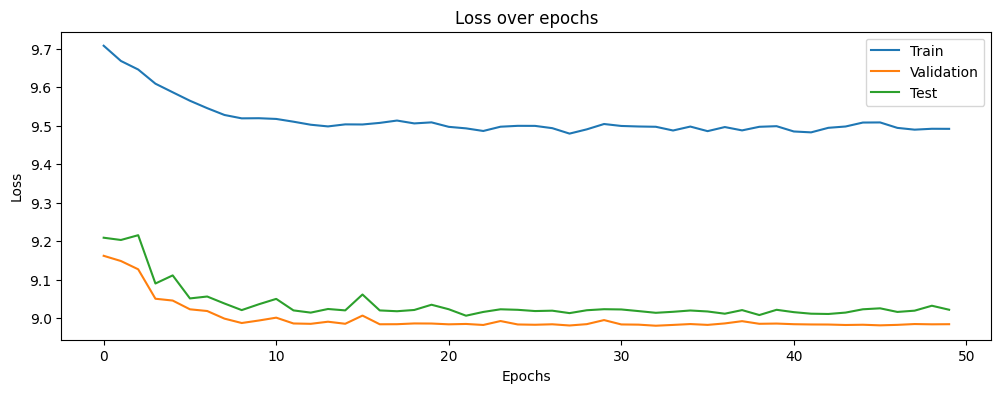

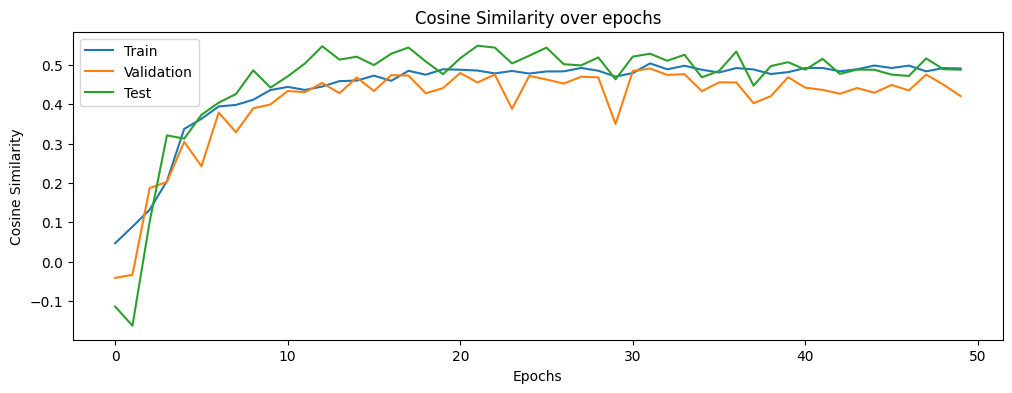

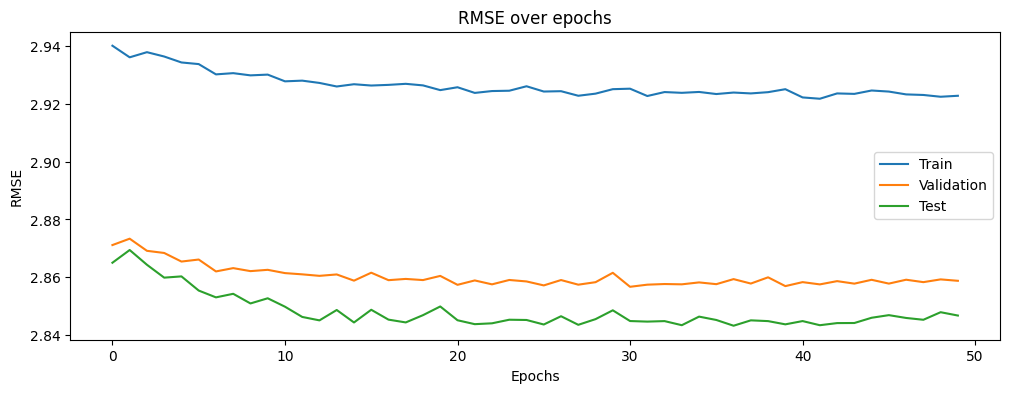

In [ ]:
# Plot losses
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.plot(test_losses, label='Test')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Cosine Sim
plt.figure(figsize=(12, 4))
plt.plot(train_cosine_sims, label='Train')
plt.plot(val_cosine_sims, label='Validation')
plt.plot(test_cosine_sims, label='Test')
plt.title('Cosine Similarity over epochs')
plt.xlabel('Epochs')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.show()

# Plot RMSE
plt.figure(figsize=(12, 4))
plt.plot(train_rmses, label='Train')
plt.plot(val_rmses, label='Validation')
plt.plot(test_rmses, label='Test')
plt.title('RMSE over epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Task 3

# Data Handling and Preprocessing

In [ ]:
def create_graph_data_task3(initial_state, trajectory):
    initial_state = np.array(initial_state)
    trajectory = np.array(trajectory)

    n_bodies = initial_state.shape[0]
    num_features = initial_state.shape[1]

    # Calculate center of mass
    total_mass = np.sum(initial_state[:, 0])
    center_of_mass_x = np.sum(initial_state[:, 1] * initial_state[:, 0]) / total_mass
    center_of_mass_y = np.sum(initial_state[:, 2] * initial_state[:, 0]) / total_mass

    # Adjust positions relative to center of mass for initial and terminal states
    initial_state[:, 1] -= center_of_mass_x
    initial_state[:, 2] -= center_of_mass_y

    trajectory[:, :, 0] -= center_of_mass_x
    trajectory[:, :, 1] -= center_of_mass_y

    # Find the indices of the two most massive objects
    mass_indices = np.argsort(initial_state[:, 0])
    indices = mass_indices[-2:]

    # Calculate the vector between the two most massive objects
    vector = initial_state[indices[1], 1:3] - initial_state[indices[0], 1:3]

    # Calculate the angle of rotation based on the vector
    angle = math.atan2(vector[1], vector[0])

    # Apply rotation to the positions
    rot_matrix = np.array([[math.cos(-angle), -math.sin(-angle)], [math.sin(-angle), math.cos(-angle)]])
    initial_state[:, 1:3] = np.matmul(rot_matrix, initial_state[:, 1:3].T).T
    for i in range(trajectory.shape[1]):
        trajectory[:, i, :2] = np.matmul(rot_matrix, trajectory[:, i, :2].T).T

    # Create node features tensor
    node_features = torch.tensor(initial_state, dtype=torch.float)
    node_features = node_features.view(-1, num_features)  # Reshape to (num_nodes, num_features)

    # Create edge index tensor
    edge_index = torch.tensor([[i, j] for i in range(n_bodies) for j in range(n_bodies) if (i != j and i < j)],
                              dtype=torch.long)
    edge_index = edge_index.t().contiguous()  # Reshape to (2, num_edges)

    # Create edge features tensor
    num_edges = edge_index.size(1)
    edge_features = torch.empty(num_edges, 1, dtype=torch.float)
    # Populate edge features with force
    for k, (i, j) in enumerate(edge_index.t()):
        dx = node_features[i, 1] - node_features[j, 1]
        dy = node_features[i, 2] - node_features[j, 2]
        distance = torch.sqrt(dx ** 2 + dy ** 2)
        force = ((node_features[i, 0] * node_features[j, 0]) / (distance ** 2 + 1e-8))
        edge_features[k] = force

    # Create target tensor
    target = torch.tensor(trajectory, dtype=torch.float).reshape(n_bodies, -1, 4)

    # Create PyG Data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=target)

    return data


# Example usage
initial_state = [[1.0, 0.5, 0.3, 0.2, 0.1], [2.0, 0.1, 0.4, 0.3, 0.2], [0.5, 0.7, 0.8, 0.9, 1.0]]
trajectory = [
    [[0.3, 0.2], [0.4, 0.3], [0.5, 0.4], [0.6, 0.5]],
    [[0.4, 0.6], [0.5, 0.7], [0.6, 0.8], [0.7, 0.9]],
    [[0.8, 0.9], [0.9, 1.0], [1.0, 1.1], [1.1, 1.2]]
]

graph_data = create_graph_data_task3(initial_state, trajectory)
print(graph_data.x, graph_data.edge_index, graph_data.edge_attr, graph_data.y)

tensor([[ 1.0000, -0.2252,  0.0762,  0.2000,  0.1000],
        [ 2.0000,  0.1871,  0.0762,  0.3000,  0.2000],
        [ 0.5000, -0.2980, -0.4574,  0.9000,  1.0000]]) tensor([[0, 0, 1],
        [1, 2, 2]]) tensor([[11.7647],
        [ 1.7241],
        [ 1.9231]]) tensor([[[-0.0554,  0.2217, -0.1282,  0.1005],
         [-0.2010, -0.0208, -0.2737, -0.1421]],

        [[-0.0554, -0.1906, -0.1282, -0.3118],
         [-0.2010, -0.4331, -0.2737, -0.5544]],

        [[-0.3707, -0.5786, -0.4435, -0.6999],
         [-0.5163, -0.8212, -0.5890, -0.9424]]])


In [ ]:
def create_dataloader_task3(data_folder, task, shuffle, batch_size, train_ratio=0.8):
    data_list = []  # List to store the Data objects

    # Loop over all files in the folder
    for filename in os.listdir(data_folder):
        file_path = os.path.join(data_folder, filename)

        # Read the data from the file (modify this part based on your file format)
        states = load_array(file_path, task=task)
        initial_state, trajectory = states

        # Create the Data object using create_graph_data function
        data = create_graph_data_task3(initial_state, trajectory)

        # Handle NaN values in the target data only for the test set
        if "test" in data_folder:
            if torch.isnan(data.y).any():
                nan_mask = torch.isnan(data.y)
                data.y[nan_mask] = torch.mean(data.y[~nan_mask])

        # Append the Data object to the list
        data_list.append(data)

    # Shuffle the data if specified
    if shuffle:
        random.shuffle(data_list)

    # Calculate the number of samples
    num_samples = len(data_list)

    if "train" in data_folder:
        # Calculate the number of samples for train and validation
        num_train = int(train_ratio * num_samples)
        num_val = num_samples - num_train

        # Split the data into train and validation sets
        train_data = data_list[:num_train]
        val_data = data_list[num_train:]

        # Print the number of data samples
        print(f"Number of data samples in {data_folder}: {num_samples}")
        print(f"Number of training samples: {num_train}")
        print(f"Number of validation samples: {num_val}")

        # Create data loaders for train and validation sets
        dataloader_train = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        dataloader_val = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        return dataloader_train, dataloader_val, data_list
    else:
        # Print the number of data samples
        print(f"Number of data samples in {data_folder}: {num_samples}")

        # Create a data loader for the data
        dataloader = DataLoader(data_list, batch_size=batch_size, shuffle=shuffle)

        return dataloader, data_list

# Specify the paths to your train and test data folders
data_folder_train = '/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/train'
data_folder_test = '/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/test'

# Define the batch size
batch_size = 50

# Create data loaders for train and validation sets (only if the folder contains "train")
dataloader_train, dataloader_val, data_list = create_dataloader_task3(data_folder_train, task='task 3', shuffle=True, batch_size=batch_size)

# Create a separate data loader for the test set
dataloader_test, data_list_test = create_dataloader_task3(data_folder_test, task='task 3', shuffle=False, batch_size=batch_size)

Number of data samples in /Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/train: 900
Number of training samples: 720
Number of validation samples: 180
Number of data samples in /Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/test: 100


# Model Implementation

In [ ]:
class GraphVAE(torch.nn.Module):
    def __init__(self):
        super(GraphVAE, self).__init__()

        # Encoder layers
        self.conv1 = SAGEConv(5, 64)
        self.conv2 = SAGEConv(64, 128)
        self.conv3 = SAGEConv(128, 256)
        self.fc_mu = Linear(256, 20)  # mu layer
        self.fc_var = Linear(256, 20)  # logvariance layer

        # Decoder layers
        self.fc1 = Linear(20, 512)
        self.fc2 = Linear(512, 512)
        self.fc3 = Linear(512, 512)
        self.fc4 = Linear(512, 256)
        self.fc5 = Linear(256, 128)
        self.fc6 = Linear(128, 64)
        self.fc7 = Linear(64, 4)

    def encode(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)  # Pooling
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, batch):
        x = F.relu(self.fc1(z))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = x[batch]  # Use the batch tensor to map each node to its corresponding graph
        return x

    def forward(self, data):
        mu, log_var = self.encode(data.x, data.edge_index, data.batch)
        z = self.reparameterize(mu, log_var)
        return self.decode(z, data.batch), mu, log_var


# Model Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
print(f'Loaded device: {device}')

Loaded device: cpu


In [ ]:
def loss_func(recon_x, x, mu, logvar, batch):
    recon_losses = []
    for i in range(batch.max().item() + 1):
        recon_x_i = recon_x[batch == i][:, :4]  # Adjust the size of recon_x_i to match 4 output features
        x_i = x[batch == i][:, :4]  # Adjust the size of x_i to match 4 features
        recon_loss_i = F.mse_loss(recon_x_i, x_i, reduction='none').sum()
        recon_losses.append(recon_loss_i)
    recon_loss = torch.stack(recon_losses).mean()
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = recon_loss + kld_loss
    return total_loss

In [ ]:
model = GraphVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def train(loader):
    model.train()
    total_loss = 0
    total_samples = 0

    for data in loader:
        data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_func(recon_batch, data.x, mu, logvar, data.batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        total_samples += data.num_graphs

    return total_loss / total_samples

def evaluate(loader):
    model.eval()
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for data in loader:
            data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = loss_func(recon_batch, data.x, mu, logvar, data.batch)
            total_loss += loss.item() * data.num_graphs
            total_samples += data.num_graphs

    return total_loss / total_samples

In [ ]:
epochs = 10
start = time.time()

train_losses = []
val_losses = []
test_losses = []

for epoch in tqdm(range(1, epochs + 1)):

    train_loss = train(dataloader_train)
    val_loss = evaluate(dataloader_val)
    test_loss = evaluate(dataloader_test)

    toc = time.time()
    print(f'EPOCH: {epoch:03d}, TRAIN LOSS: {train_loss:.4f}, VAL LOSS: {val_loss:.4f}, TEST LOSS: {test_loss:.4f}. TRAINING TIME SO FAR: {toc - start:.1f} s\n')

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

 10%|█         | 1/10 [00:00<00:02,  4.42it/s]

EPOCH: 001, TRAIN LOSS: 273.4922, VAL LOSS: 253.8482, TEST LOSS: 271.3687. TRAINING TIME SO FAR: 0.2 s



 20%|██        | 2/10 [00:00<00:01,  4.38it/s]

EPOCH: 002, TRAIN LOSS: 244.0882, VAL LOSS: 251.3596, TEST LOSS: 267.8622. TRAINING TIME SO FAR: 0.5 s



 30%|███       | 3/10 [00:00<00:01,  4.36it/s]

EPOCH: 003, TRAIN LOSS: 243.3917, VAL LOSS: 251.0100, TEST LOSS: 266.6100. TRAINING TIME SO FAR: 0.7 s



 40%|████      | 4/10 [00:00<00:01,  4.33it/s]

EPOCH: 004, TRAIN LOSS: 242.9504, VAL LOSS: 250.7969, TEST LOSS: 267.6408. TRAINING TIME SO FAR: 0.9 s



 50%|█████     | 5/10 [00:01<00:01,  4.37it/s]

EPOCH: 005, TRAIN LOSS: 242.6897, VAL LOSS: 250.6961, TEST LOSS: 266.8099. TRAINING TIME SO FAR: 1.1 s



 60%|██████    | 6/10 [00:01<00:00,  4.32it/s]

EPOCH: 006, TRAIN LOSS: 242.7795, VAL LOSS: 251.7592, TEST LOSS: 267.6027. TRAINING TIME SO FAR: 1.4 s



 70%|███████   | 7/10 [00:01<00:00,  4.37it/s]

EPOCH: 007, TRAIN LOSS: 243.4462, VAL LOSS: 251.0942, TEST LOSS: 266.4288. TRAINING TIME SO FAR: 1.6 s



 80%|████████  | 8/10 [00:01<00:00,  4.39it/s]

EPOCH: 008, TRAIN LOSS: 243.0988, VAL LOSS: 250.5232, TEST LOSS: 266.1964. TRAINING TIME SO FAR: 1.8 s



 90%|█████████ | 9/10 [00:02<00:00,  4.40it/s]

EPOCH: 009, TRAIN LOSS: 242.6756, VAL LOSS: 250.7455, TEST LOSS: 267.0733. TRAINING TIME SO FAR: 2.1 s



100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

EPOCH: 010, TRAIN LOSS: 242.6881, VAL LOSS: 250.1976, TEST LOSS: 266.5088. TRAINING TIME SO FAR: 2.3 s

